#### Base idea about the high res files:
- High-quality images for reconstruction (undistorted)
- Ground truth for evaluation (scan_eval)
- Occlusion information for handling complex scenes

#### Data components:    
#### Low-Resolution Multi-View:
- Similar scenes but captured at lower resolutions
- Useful for testing algorithms' performance with less detailed input
- Good for initial testing as they process faster    

#### Single-View:
- Individual images with depth information
- Used for testing single-image depth estimation

#### RAW Images:
- Unprocessed camera sensor data
- Contains more information but requires additional processing
- Useful for advanced photogrammetry

#### Distorted Images:
- Original images before lens distortion correction
- Used when working with raw camera calibration

#### Calibration Details:
- Camera parameters (intrinsic and extrinsic)
- Focal lengths, principal points, distortion coefficients
- Essential for accurate 3D reconstruction

---

#### Example scene structures:
- courtyard/: 38 images, structured movement
- facade/: 74 images, systematic coverage
- office/: 26 images, more confined space
- pipes/: 14 images, linear movement pattern
- Capture Pattern: Often follows a semi-structured pattern where images are taken in sequence with moderate overlap
- Scene Types: Mix of indoor (office, pipes) and outdoor (courtyard, facade) scenes
- Camera Movement: Generally systematic, not random
- Ground Truth: Includes precise camera calibration and poses
  
--------------------------------------------------------------------------------------------------------------------------------------------

### Part 1
Core ImageDataset class for batch processing
GPU-accelerated preprocessor with CLAHE and denoising
Feature extractor with SIFT support and metric computation

### Part 2:

SceneManager for handling dataset organization and scene selection
ResultsManager for saving/loading preprocessing results
ResultAnalyzer for analyzing and visualizing results
HDF5 storage for feature data, JSON storage for metrics and metadata, Automated scene complexity estimation..
Image Stats Class for Stats on Images/Scenes that could be useful
Result analysis and visualization, Error handling and logging, etc.

### Part 3:
Configuration management using dataclasses.
Pipeline orchestration with parallel processing, Complete error handling and logging, Main usage.

--------------------------------------------------------------------------------------------------------------------------------------------

## BASICS PHASE 1
#### Method setup_gpu_processing():
- torch_cuda: Indicates if PyTorch can utilize CUDA (GPU) acceleration.
- opencv_cuda: Indicates if OpenCV has CUDA support enabled.
- cuda_sift: Specifies whether CUDA-accelerated SIFT feature detection is available.
- device: Specifies the default processing device ('cpu' or 'cuda').
- gpu_info: Contains information about the GPU, such as its name.
- memory_info: Details GPU memory statistics, including total and allocated memory.

#### CUDA Optimizations:
- torch.backends.cudnn.benchmark: 
    Enables the cuDNN auto-tuner to find the best algorithm for your hardware, optimizing performance.
- torch.set_default_tensor_type('torch.cuda.FloatTensor'): 
    Sets the default tensor type to CUDA-enabled tensors, ensuring that tensors are allocated on the GPU by default.
- cv2.cuda.getCudaEnabledDeviceCount(): 
    Verify if OpenCV can access any CUDA-enabled devices.

#### Logging Configuration Summary:
- Provides a comprehensive summary of the GPU's capabilities and status.
- PyTorch CUDA Availability, OpenCV CUDA Availability, CUDA SIFT Availability, GPU Info.
- ( returned gpu_config dictionary can be incorporated into the ProcessingConfig dataclass. )

#### Data Flow:
1. GPU Setup → Scene Loading → Image Preprocessing
2. Feature Extraction → Results Analysis → Storage


#### PyTorch Functions in the 3D Reconstruction Pipeline

#### Mixed Precision and Memory Optimization:
- **torch.cuda.amp.autocast()**: Enables Automatic Mixed Precision (AMP) to dynamically switch between 16-bit and 32-bit precision during model training, enhancing performance and reducing memory usage.
- **torch.cuda.empty_cache()**: Releases unused cached memory held by the GPU allocator, useful for freeing resources after specific operations.
- **torch.cuda.is_available()**: Checks if CUDA (GPU support) is available for PyTorch, allowing dynamic device allocation.
- **torch.backends.cudnn.benchmark = True**: Activates cuDNN auto-tuner, optimizing performance by choosing the most efficient algorithm for specific hardware.
- **torch.set_default_tensor_type('torch.cuda.FloatTensor')**: Sets the default tensor type to GPU tensors, streamlining tensor allocation on GPU without needing explicit `.to()` calls.

#### Device and Tensor Allocation:
- **torch.device('cuda' if torch.cuda.is_available() else 'cpu')**: Determines whether to allocate tensors on GPU or CPU based on availability.
- **torch.Tensor.to(device)**: Moves a tensor to the specified device, essential for performing calculations on GPU if available.
- **torch.cuda.get_device_properties()**: Retrieves GPU specifications (e.g., memory capacity), useful for adjusting batch sizes and computational load based on available resources.
- **torch.cuda.memory_allocated()**: Monitors the GPU memory currently occupied by tensors, assisting in memory management and avoiding out-of-memory issues.

#### Tensor Operations and Matrix Multiplication:
- **torch.matmul()**: Performs matrix multiplication, critical for linear transformations, such as color space conversions (RGB to XYZ) and camera projection calculations in 3D reconstruction.
- **torch.pow()**: Raises each element of a tensor to a specified power, applied in non-linear transformations for gamma correction or color space adjustments.
- **torch.from_numpy()** and **torch.Tensor.numpy()**: Converts between PyTorch tensors and NumPy arrays, useful for interfacing with libraries like OpenCV.
- **torch.clamp()**: Constrains tensor values within a specified range, ensuring valid pixel intensity or color channel values.
- **torch.Tensor.reshape()**: Adjusts tensor shape without altering data, aligning tensor dimensions for transformations or matrix operations.
- **torch.Tensor.transpose()** and **torch.Tensor.permute()**: Reorders tensor dimensions, often needed for format compatibility across different libraries or for visualizing 3D data.
- **torch.cat()**: Concatenates multiple tensors along a specified dimension, helpful in assembling multi-channel images or stacking point cloud data.

#### Data Handling and Conversion:
- **torch.zeros_like()**: Creates a tensor filled with zeros matching the shape and type of a given tensor, useful for allocating space for transformed data.
- **torch.tensor()**: Initializes a tensor with specified data and device, such as defining transformation matrices or camera intrinsic parameters for projections.
- **torch.set_default_tensor_type()**: Sets a default tensor type, often helpful in 3D reconstructions to default tensors to GPU or a specific floating-point precision.

#### Gradient and Optimization Tools:
- **torch.autograd.grad()**: Computes gradients of tensors, useful for backpropagation through custom layers or operations in 3D tasks.
- **torch.no_grad()**: Disables gradient computation in a block, optimizing memory usage for inference tasks like rendering or point cloud processing.
- **torch.optim.Adam()** and **torch.optim.SGD()**: Common optimizers to update model weights, essential for learning in neural networks involved in feature extraction or depth prediction.
- **torch.nn.functional.relu()**: Applies the ReLU activation function, standard for neural networks in feature extraction modules.

#### Additional PyTorch Functions Useful for 3D Reconstruction and PyTorch3D:
- **torch.nn.functional.grid_sample()**: Samples input tensors using a grid, helpful in projecting 2D images to 3D space for view synthesis or multi-view stereo.
- **torch.nn.functional.interpolate()**: Resizes tensors, useful for scaling depth maps or images to match target resolution in multi-view settings.
- **torch.nn.functional.cosine_similarity()**: Calculates cosine similarity between tensors, applicable in comparing feature descriptors or matching keypoints.
- **torch.save()** and **torch.load()**: Saves and loads tensors or models, facilitating checkpointing during lengthy 3D reconstruction processes.
- **torch.linalg.svd()**: Computes Singular Value Decomposition, often used in solving matrix equations, such as fundamental matrix estimation in Structure from Motion (SfM).

#### PyTorch3D-Specific Functions:
- **pytorch3d.renderer.TexturesVertex()**: Applies vertex colors to a mesh, enhancing visualization of 3D structures.
- **pytorch3d.renderer.PointLights()**: Adds point light sources for illuminating 3D models, creating realistic rendering of reconstructed surfaces.
- **pytorch3d.renderer.MeshRenderer()**: Renders a 3D mesh, producing 2D images from a specified camera perspective.
- **pytorch3d.structures.Pointclouds()**: Encapsulates point cloud data in a format compatible with PyTorch3D operations, facilitating point-based 3D reconstructions.
- **pytorch3d.transforms.Rotate()** and **pytorch3d.transforms.Translate()**: Provides transformation utilities for 3D data, enabling rotation and translation of point clouds or meshes.

#### PyVista and Trimesh Integration:
- **pv.Plotter()** (PyVista): Sets up an interactive visualization window for 3D meshes, point clouds, and surfaces.
- **mesh.slice()** (Trimesh): Cuts a 3D mesh along a plane, useful for analyzing cross-sections of reconstructed surfaces.
- **mesh.sample()** (Trimesh): Samples points from a mesh, helpful for generating synthetic data or reducing complexity in dense reconstructions.

#### Class GPUAcceleratedPreprocessor

- Batch Size Configuration:
    self.batch_size: Determines the number of images processed in a single batch.
- Color Space Conversion Matrices:
    self.rgb_to_xyz and self.xyz_to_rgb: Predefined matrices for converting between RGB and XYZ color spaces, essential for subsequent LAB conversions.
- Placement on Device: 
    Ensures that these matrices reside on the designated processing device.
- Enhancement Parameters:
    - self.clahe: Initializes the CLAHE (Contrast Limited Adaptive Histogram Equalization) with specified parameters, enhancing local contrast in images.
    - self.bilateral_params: Defines parameters for bilateral filtering, which reduces noise while preserving edges.
- Logging Initialization Status:
    self._log_initialization(): Logs details about the preprocessor's initialization.

#### CLAHE Enhancement:
- L Channel Processing: Extracts the L (lightness) channel from the LAB image, transfers it to the CPU, and applies CLAHE for local contrast enhancement using the _enhance_l_channel method.
- Reconstruction: Combines the enhanced L channel back with the original A and B channels to reconstruct the LAB image.
- CLAHE improves visibility in regions with low contrast, making features more distinguishable for subsequent feature extraction. Avoiding Over-Enhancement: By setting a clipLimit, CLAHE prevents excessive amplification of noise, maintaining image quality.
- Tile Grid Size: Determines the size of local regions for contrast enhancement, balancing between global and local adjustments.
- Batch Processing: Enhancing the L channel for an entire batch simultaneously optimizes processing time and resource utilization.

#### Denoising:
- Bilateral Filtering: Applies bilateral filtering using the _apply_denoising method on the CPU to reduce noise while preserving edges.
- Iterative Denoising: Applies OpenCV's bilateralFilter to each image in the batch using predefined parameters (d=5, sigmaColor=75, sigmaSpace=75).
- CPU-Based Denoising: Since OpenCV's bilateral filtering isn't GPU-accelerated in this setup, performing it on the CPU ensures compatibility and leverages optimized OpenCV implementations.

#### Where are the formulas from?: using the CIE 1976 LAB color space formulas.

#### Core: Image Prep: 
- Converts raw images into a standardized color space (LAB), enhances contrast, and reduces noise, setting the stage for accurate and efficient feature extraction.
- CLAHE, Local Contrast Enhancement, Noise Prevention: Enhances details in specific regions without affecting the entire image, ensuring that both bright and dark areas are appropriately contrasted. "Contrast Limited" aspect prevents excessive amplification of noise, maintaining image quality.
- ( CLAHE, Why Chosen: Unlike global histogram equalization, CLAHE operates on small regions, preventing over-amplification of noise and preserving important features. Enhancement?: Ensures that contrast enhancement doesn't distort the image, maintaining a balance between visibility and natural appearance. )
- Color Channel Conversion (RGB to XYZ to LAB):
    - Separation of Luminance and Color: Allows independent processing of brightness and color, which is beneficial for tasks like contrast enhancement.
    - Perceptual Uniformity: LAB color space aligns more closely with human vision, making color-based processing more effective.
    - Improved Feature Detection: Enhanced luminance in LAB can lead to more accurate feature extraction, crucial for 3D recon.
    - Alignment with Human Vision: LAB is designed to be perceptually uniform, meaning that changes in the color space correspond more closely to how humans perceive changes in color and brightness.


#### **Class FeatureExtractor**

- **Feature Detector and Descriptor Configuration:**
  - `self.detector`: Initializes the feature detector (e.g., SIFT, SURF, ORB) for identifying keypoints in the image.
  - `self.descriptor`: Defines the descriptor method, which computes a feature vector for each detected keypoint, enabling matching between images.

- **Keypoint Detection and Description:**
  - `detect_and_describe()`: Extracts keypoints and computes descriptors, forming the core input for matching algorithms in 3D reconstruction.
  - **Scale and Rotation Invariance:** Ensures robustness to changes in scale, orientation, and lighting, vital for accurate feature matching across varied viewpoints.
  - **Feature Density Control:** Adjusts parameters like `contrastThreshold` or `nfeatures` (in SIFT or ORB) to control the number and distribution of detected keypoints.

- **Matching Strategy:**
  - `match_features()`: Uses a matching strategy (e.g., BFMatcher, FLANN) to match descriptors between images, fundamental for scene consistency in 3D reconstruction.
  - **Ratio Test (Lowe’s Ratio):** Filters matches by comparing the distance ratio of the closest to the second-closest match, reducing incorrect matches.
  - **Bidirectional Consistency Check:** Ensures mutual match consistency by only retaining matches that are reciprocal, increasing reliability.

- **Outlier Rejection:**
  - **RANSAC-based Filtering:** Applies RANSAC to refine matches, removing outliers by estimating a homography or fundamental matrix, which maintains geometric consistency.
  - **Epipolar Constraints:** Enforces geometric constraints on matched points, essential for coherent feature alignment across images.

- **Pre-Processing:**
  - **Gray-Scaling:** Converts images to grayscale before feature extraction to focus on intensity variations, reducing computational overhead and avoiding color-related inconsistencies.
  - **ROI (Region of Interest):** Limits feature detection to specific areas, if defined, to enhance performance in complex scenes.

- **Intuition for 3D Reconstruction:**
  - **Consistency Across Views:** Robust feature extraction and matching are essential for maintaining consistent scene geometry across multiple views.
  - **Accuracy in Feature Representation:** Ensures each feature vector captures unique characteristics, improving the reliability of subsequent triangulation and 3D point cloud creation.
  - **Adaptability Across Scales and Rotations:** Enables effective matching in scenarios with varied perspectives, supporting depth estimation in 3D reconstruction pipelines.

---- 

#### Possible Next Steps?
- Selective Matching with a "Local + Global" strategy.
- Match sequential pairs (i with i+1) as base:
    - Add selective global matches based on: * View overlap estimation, * Feature similarity, * Distance between camera positions.
    - ETH3D scenes often have loop closures, Need to balance computation and accuracy, Need to handles both ordered and unordered image sets.

- The relationship between SceneManager and CorrespondenceManager is about maintaining scene coherence.
    - SceneManager handles scene-level organization. Feature correspondences are scene-specific data.

- Maintain feature ID consistency
    - Support query operations like:
    - "Show all images where feature X appears", "Get all features shared between images A and B", "Find longest feature tracks in scene".

--- 

    Scene
      ├── Image1 ──┐
      ├── Image2 ──┼── Feature Correspondences
      ├── Image3 ──┤     - Feature ID tracking
      └── Image4 ──┘     - Match consistency
    Scene "courtyard"
      ├── DSC_001.jpg ── Feature #123 appears
      ├── DSC_002.jpg ── Feature #123 tracked
      ├── DSC_003.jpg ── Feature #123 still visible
      └── DSC_004.jpg ── Feature #123 disappears

---

    Step 1: Quick distance check (very fast)
       ↓
    Step 2: Frustum overlap (fast)
       ↓
    Step 3: Descriptor similarity (moderate)
       ↓
    Step 4: Feature matching (expensive)

    ---
    
    graph TD
        A[SceneManager] -->|scene_meta| B[PipelineOrchestrator]
        B -->|image_paths, poses| C[ImageDataset]
        C -->|batches with poses| D[Preprocessor]
        D -->|processed images| E[FeatureExtractor]
        E -->|features| F[FeatureMatcher]
        F -->|matches| G[CorrespondenceManager]
        G -->|results| H[ResultsManager]
    
        

#### Rough Example:
For each image i:
  1. Find potential neighbors:
     - Within distance threshold
     - With overlapping view frustums
     
  2. For potential neighbors:
     - Compute quick similarity score
     - Keep top K neighbors
     
  3. For kept neighbors:
     - Perform full feature matching
     - Apply ratio test and RANSAC
       
---
        Raw Matches
           │
           ↓
        Ratio Test (fast initial filter)
           │
           ↓
        RANSAC (geometric verification)
           │
           ↓
        Final Filtered Matches

#### Storage Hierarchy ideas.. 

    Scene
    ├── Raw Matches (temporary)
    ├── Filtered Matches (after ratio test)
    ├── Verified Matches (after RANSAC)
    └── Feature Tracks (correspondence chains)

---

#### **Class SceneManager**

- **Scene Initialization and State Tracking:**
  - `initialize_scene()`: Sets up the initial state of the scene, preparing data structures for images, keypoints, and matches.
  - **Scene Structure Representation:** Maintains mappings of images, feature points, and relative poses to form a coherent 3D model.
  - **Keypoint Association:** Links extracted keypoints from the `FeatureExtractor` across different views, essential for scene integrity.

- **3D Point Cloud Assembly:**
  - `add_point_to_scene()`: Integrates triangulated 3D points into the scene, progressively building the scene's point cloud.
  - **Depth Calculation and Triangulation:** Uses matched features to triangulate depth, producing a spatial representation of the scene.
  - **Point Filtering:** Applies distance-based filters to retain only reliable 3D points, reducing noise in the reconstructed model.

- **Pose Estimation and Camera Calibration:**
  - `estimate_pose()`: Estimates camera poses based on matched keypoints and their geometric constraints, setting the foundation for scene alignment.
  - **Bundle Adjustment:** Performs iterative optimization to refine camera parameters and 3D points, minimizing reprojection error for a more accurate model.
  - **Intrinsic and Extrinsic Parameters:** Manages calibration data, ensuring correct perspective representation for each image in the 3D scene.

- **Scene Refinement and Consistency Checks:**
  - **Outlier Rejection:** Implements spatial consistency checks to remove points that don’t fit the overall scene structure.
  - **Consistency Across Frames:** Maintains frame-to-frame consistency to ensure that the 3D model is coherent as more images are added.
  - **Reprojection Validation:** Projects 3D points back to image planes to validate alignment, ensuring each point remains consistent across multiple views.

- **Scene Storage and Retrieval:**
  - **Sparse Structure Representation:** Maintains a sparse representation of the 3D scene to save memory, storing only essential points.
  - **Efficient Data Retrieval:** Organizes scene data to allow efficient querying and update, especially for adding new images or recalculating structures.
  - **Scene Export:** Prepares data for export into formats compatible with visualization software or further processing in 3D reconstruction pipelines.

- **Intuition for 3D Reconstruction:**
  - **Accurate Scene Representation:** Ensures that the reconstructed scene faithfully represents spatial relationships between points.
  - **Depth Accuracy:** Maintains high depth accuracy, which is crucial for real-world applications like VR and AR.
  - **Scalability:** Designed to handle an increasing number of images and points, allowing for expansion in large-scale 3D reconstructions.

---

- **FeatureExtractor Flow**:

        Initialize → self.detector (e.g., SIFT or ORB) and self.descriptor →
        Detect and Describe (detect_and_describe) → Detects keypoints →  Extracts descriptors; → Return → Keypoints and Descriptors.

-  **SceneManager Flow**:

    -  Initialize Scene (initialize_scene) → self.frames to store image frames with keypoints and descriptors. ;
    -  Match Keypoints (match_keypoints) → Matches descriptors()  → Outputs initial matches based on distance → Filter Matches (filter_matches) →
    - Applies filtering ().  → Refine matches, keeping high-confidence matches only. →
    - Return → Matched and filtered keypoints for further processing in reconstruction tasks.

### Selective Matching Criteria Analysis - Concepts Used Later in FeatureMatcher and CorrespondenceMatcher

View Overlap Estimation:
- Using camera poses and field of view; Frustum intersection check; Viewing angle difference.

Example:
Camera A (position, orientation) → Frustum A
Camera B (position, orientation) → Frustum B
Overlap = intersect(Frustum A, Frustum B)

Feature Similarity:
- Global image descriptors (faster than full feature matching), Histogram comparison, GIST descriptors.
- lightweight descriptor per image (once) -> descriptors for potential pairs -> Select pairs above similarity threshold

Camera Position Distance
- Euclidean distance between camera centers, Relative camera orientation, Baseline ratio
- Extract camera positions from metadata; Compute pairwise distances; Select pairs within distance threshold
- 
#### Feature Descriptor Management:
    ✅ Properly handling descriptors in feature extraction
    ✅ Storing descriptors efficiently
    ✅ Using descriptors in matching
    ✅ Tracking descriptor-related statistics
    ✅ Integrating with scene-adaptive matching

----
----

#### Key Complex Items;

#### 1. Scene-Adaptive Processing
- Scene type detection and classification, Type-specific parameter adjustment, Adaptive matching strategies
#### 2. Efficient Feature Management
- Integrated descriptor handling, Compressed storage solutions, Quality-based filtering
#### 3. Smart Matching Strategy
- Sequential vs non-sequential balance, Overlap-based pair selection, Scene-specific match validation
#### 4. Advanced Correspondence Handling
- Track-based feature management, Scene-aware track filterin, Statistical validation

---

## Matching Components Deep Analysis: MatchConfig and MatchQualityMetrics

## MatchConfig
### Core Configuration Design:
- **Scene-Adaptive Parameters**
  - `scene_type`: Controls matching behavior based on scene characteristics (CONFINED, STRUCTURED, OPEN)
  - `sequential_weight`: Balances between sequential and non-sequential matching emphasis (0.7 default)
  - Distance and angle thresholds adapted per scene type

### Matching Strategy Parameters:
- **Distance-Based Controls:**
  - `max_distance_threshold`: Maximum allowed camera distance for matching (30.0 units)
  - Prevents matching between views that are too far apart
  - Scene-specific thresholds through `distance_thresholds` dictionary

- **View Overlap Controls:**
  - `min_overlap_threshold`: Minimum required view frustum overlap (0.3 or 30%)
  - `similarity_threshold`: Feature similarity requirement (0.4)
  - Ensures meaningful geometric relationships between views

- **Neighboring Views:**
  - `max_neighbors`: Limits number of matching candidates per image (5)
  - Balances between coverage and computational efficiency
  - Critical for managing matching complexity in large scenes

### FLANN Matching Parameters:
- **Index Configuration:**
  - Algorithm selection (KD-tree) / - Tree count optimization /  - Search checks balance between speed and accuracy

### Quality Thresholds:
- `ratio_test_threshold`: Lowe's ratio test (0.75)
- `ransac_threshold`: Geometric verification tolerance (4.0 pixels)
- `min_inlier_ratio`: Minimum acceptable inlier percentage (0.5)
- `min_matches`: Minimum matches to validate a pair (20)

### Track Management:
- `max_track_length`: Prevents excessive track length (20) / - `min_track_length`: Minimum track length for validity (3)
- Balances between track completeness and reliability

## MatchQualityMetrics

### Pose-Based Quality Assessment:
- **Triangulation Analysis:**
  - Computes 3D rays for matched features  / - Analyzes intersection angles /  - Estimates reconstruction reliability /  - Key for identifying well-conditioned matches

### Geometric Quality Metrics:
- **Epipolar Geometry:**
  - `compute_epipolar_errors`: Measures geometric consistency /  - Fundamental matrix validation /  - Identifies mismatches through geometric constraints

### Spatial Distribution Analysis:
- **Coverage Assessment:**
  - Grid-based distribution analysis /  - Uniform feature spread verification /  - Identifies matching gaps or clusters

### Match Quality Indicators:
- Mean/max epipolar errors / - Spatial consistency scores / - Descriptor distance statistics / - Critical for match filtering and validation

### Integration with Pipeline:
- Provides feedback for match filtering / - Guides parameter adaptation / - Supports quality-based visualization / - Enables adaptive threshold adjustment

### Statistical Analysis:
- **Comprehensive Metrics:**
  - Track length distribution /  - Match density patterns /  - View overlap statistics /  - Essential for quality assurance

### Quality Visualization:
- Distribution plots / - Error histograms / - Coverage maps / - Critical for quality assessment

### Key Features:
1. **Pose Integration:**
   - Utilizes camera positions and orientations / - Validates geometric relationships / - Ensures consistent 3D structure

2. **Quality Assessment:**
   - Multi-metric evaluation / - Statistical validation / - Error quantification

3. **Adaptive Thresholding:**
   - Scene-specific adjustments / - Quality-based filtering / - Dynamic parameter tuning

### Implementation Considerations:
   - Optimized metric computation, Selective quality assessment, Resource-aware processing
   - Handles missing pose data, Manages outliers, Provides fallback metrics
   - Seamless pipeline integration, Clear quality feedback, Actionable metrics


# FeatureMatcher and CorrespondenceManager Deep Analysis

## Core Matching Strategy

### View Overlap Computation Logic:
- **Core Algorithm Flow:** Extracts positions and directions from poses, computes distance score using max threshold normalization, calculates viewing direction alignment through dot products, determines relative position direction for frustum analysis, integrates using scene-type weighted combinations.
- **Geometric Reasoning:** Distance score ensures spatial proximity, angle score validates view alignment, frustum score confirms camera field-of-view overlap, weighted combination adapts to scene characteristics like confined spaces vs open areas.
- **Scene Adaptivity:** CONFINED scenes prioritize distance (0.5 weight) due to space constraints, STRUCTURED scenes balance distance and angle (0.4 each), OPEN scenes emphasize angle (0.5 weight) due to wider viewpoint variations.

### Selective Pair Matching Strategy:
- **Sequential Base:** Always matches consecutive frames for temporal consistency, validates poses if available, ensures continuous reconstruction backbone.
- **Non-Sequential Extensions:** Adds selective global matches based on pose overlap, feature similarity, camera distances, critical for loop closures and robust reconstruction.
- **Optimization Approach:** Combines overlap scores with distance-based filtering, ranks candidate pairs by combined score, selects top-K neighbors based on scene type and matching config.

### FLANN-Based Feature Matching:
- **Matching Process:** Converts descriptors to appropriate format, applies FLANN kNN matching with k=2 for ratio test, filters matches using Lowe's ratio test threshold, ensures descriptor type compatibility and normalization.
- **Efficiency Considerations:** Uses FLANN indexing (KD-tree for SIFT descriptors), optimizes search parameters based on descriptor dimensionality, balances accuracy vs speed through checks parameter.
- **Quality Control:** Applies ratio test for initial filtering, performs geometric verification through RANSAC, computes fundamental matrix for additional validation, maintains minimum match count thresholds.

## Geometric Verification and Validation

### Fundamental Matrix Estimation:
- **RANSAC Implementation:** Uses cv2.findFundamentalMat with RANSAC, applies pixel-based threshold for inlier determination, ensures minimum sample size (8 points), adapts maximum iterations based on confidence requirement.
- **Quality Metrics:** Computes inlier ratio relative to initial matches, validates against minimum inlier threshold, ensures geometric consistency through epipolar constraints, provides feedback for match quality assessment.
- **Error Handling:** Manages degenerate cases where fundamental matrix estimation fails, provides fallback mechanisms for pose-based validation, ensures robust pipeline continuation.

### Pose-Aware Match Validation:
- **Geometric Constraints:** Validates matches using relative camera positions, ensures consistency with epipolar geometry, combines both feature similarity and geometric constraints.
- **Scene-Type Integration:** Adapts validation thresholds based on scene type, applies stricter geometric constraints in structured environments, relaxes constraints in challenging scenarios.
- **Quality Assessment:** Integrates with MatchQualityMetrics for comprehensive validation, provides feedback for parameter adjustment, guides match filtering decisions.

## Correspondence Management

### Track Initialization and Management:
- **Data Structure:** Maintains mappings between feature indices and track IDs, efficiently handles feature-to-track relationships, optimizes memory usage through sparse representation.
- **Track Creation:** Generates new tracks for unmatched features, assigns unique track IDs, maintains track consistency across multiple views, handles track merging when necessary.
- **Feature Mapping:** Creates bidirectional mappings between features and tracks, enables efficient query operations, supports track length and quality analysis.

### Track Merging and Consistency:
- **Merge Logic:** Identifies overlapping tracks through common features, combines tracks while maintaining consistency, resolves conflicts based on track quality metrics.
- **Conflict Resolution:** Handles cases where features belong to multiple tracks, applies quality-based decision making, ensures track integrity through validation.
- **Update Strategy:** Efficiently updates track information when new matches arrive, maintains track statistics during updates, provides feedback for track quality assessment.

### Track Analysis and Statistics:
- **Length Analysis:** Computes track length distributions, identifies stable features through long tracks, provides insights for reconstruction reliability.
- **Coverage Analysis:** Analyzes spatial distribution of tracks, identifies areas with poor tracking, guides feature detection and matching parameters.
- **Quality Metrics:** Tracks feature persistence across views, computes track stability metrics, supports reconstruction quality assessment.

## Efficiency and Optimization

### Memory Management:
- **Data Structures:** Uses efficient storage for tracks and correspondences, implements lazy computation of statistics, optimizes memory usage through sparse representations.
- **Batch Processing:** Processes matches in batches for efficiency, maintains memory bounds during track updates, implements cleanup for obsolete track data.
- **Resource Utilization:** Balances CPU and memory usage, implements efficient search structures for track queries, optimizes data access patterns.

### Performance Optimization:
- **Search Efficiency:** Uses hash tables for feature-track mappings, implements efficient track merging algorithms, optimizes query operations for large datasets.
- **Algorithmic Choices:** Selects efficient data structures for track storage, implements fast lookup mechanisms for feature queries, optimizes track update operations.
- **Scalability:** Handles large numbers of tracks efficiently, scales well with increasing dataset size, maintains performance through optimized algorithms.

### Error Recovery and Robustness:
- **Exception Handling:** Manages matching failures gracefully, provides fallback mechanisms for track updates, ensures pipeline continuity despite local failures.
- **Data Validation:** Verifies track consistency during updates, validates match quality before track creation, ensures robust reconstruction through quality checks.
- **Recovery Mechanisms:** Implements strategies for handling broken tracks, provides mechanisms for track repair, maintains reconstruction quality despite local failures.


### Visualization Methods Analysis for 3D Reconstruction Pipeline

### Core Components and Their Purpose

1. **Feature Match Visualization**
   **Core Concept:** Visualize how features are matched between images for reconstruction.
   
   **Methods:**
   - Pair-wise Match Display:
     * Shows direct correspondences between two images / * Color codes inliers (green) and outliers (red)
     * Essential for verifying match quality and RANSAC effectiveness
   
   - Sequential Match Visualization:
     * Displays matches across consecutive frames / * Helps understand feature tracking consistency
     * Critical for identifying gaps in feature correspondence

   **Intuition:**
   - Good matches should be well-distributed across images
   - Clustering of matches might indicate bias
   - Inlier/outlier ratio helps validate geometric verification

2. **Camera Pose Visualization**
   **Core Concept:** Visualize camera movement and coverage for understanding scene capture.
   
   **Methods:**
   - Camera Path Display:
     * Shows 3D trajectory of camera positions / * Visualizes camera orientations with coordinate axes
     * Helps verify scene coverage completeness
   
   - View Overlap Analysis:
     * Heat map of view overlaps between camera pairs / * Essential for understanding reconstruction reliability
     * Helps identify potentially problematic areas

   **Intuition:**
   - Good reconstruction needs sufficient view overlap / Camera path should be smooth and well-distributed / Gaps in coverage may lead to recon issues.


3. **Feature Distribution Analysis**:
    **Core Concept:** Analyze spatial distribution, persistence, and characteristics of detected features.
    
    **Methods:**
    Feature Density Map: Grid-based density computation, coverage visualization, hotspot identification
    Track Length Analysis: Track persistence visualization, length distribution, temporal stability analysis
    Comprehensive Analysis: Response strength, scale distribution, spatial spread, track quality metrics
    
    **Intuition:**
    Good coverage needs uniform feature distribution, stable tracks indicate reliable features, balanced scale distribution ensures multi-scale reconstruction

---

1. **Match Visualization & Quality**
Components: Pair-wise matches, sequential tracking, color-coded inliers/outliers, statistical overlays
Purpose: Match verification, RANSAC validation, tracking consistency checks
Usage: On-demand generation, immediate feedback, parameter tuning guidance

2. **Camera Movement & Coverage**
Components: 3D path visualization, orientation display, overlap analysis, frustum visualization
Purpose: Scene coverage verification, movement pattern analysis, view relationship understanding
Usage: Path smoothness verification, coverage gap identification, reconstruction planning

3. **Feature Analysis & Distribution**
Components: Density heatmaps, track persistence plots, response distribution, scale analysis
Purpose: Feature quality assessment, distribution uniformity check, tracking stability verification
Usage: Feature detector evaluation, tracking performance analysis, reconstruction feasibility assessment


---
------


---

### Integration

1. **Quality Control Chain**
Input validation: Feature distribution → Match quality → Camera pose consistency
Analysis flow: Spatial coverage → Temporal stability → Geometric consistency
Feedback loop: Visual insights → Parameter adjustments → Quality improvement

2. **Reconstruction Planning**
Coverage assessment: Feature density + Camera positions + View overlaps
Quality metrics: Track length + Match inliers + Pose consistency
Decision support: Additional views needed, parameter adjustments required, problematic areas identified

3. **Performance Optimization**
Resource efficiency: On-demand visualization, no storage overhead, quick generation
Analysis efficiency: Combined views, statistical summaries, clear visual patterns
Development efficiency: Modular design, consistent styling, extensible structure

Primary Goals: Clean visualization, informative metrics, efficient computation
Design Principles: Modularity, on-demand generation, comprehensive analysis
Usage Pattern: Quality check → Analysis → Adjustment → Verification

---


        * Pipeline Flow:
        Feature Extraction → Matching → Visualization
                                          ↓
                                Quality Assessment
                                          ↓
                             Reconstruction Planning




----

#### Already has visualizations for:
- Feature count distribution plots / - Coverage distribution plots / - Quality metrics visualization / - Scene-level statistics plots
- Key method: visualize_results(self, scene_stats: SceneStats, image_stats: List[ImageStats], save_path: Optional[Path] = None)

#### SceneManager basic visualization for:
- Scene complexity distribution / - Scene statistics printing

#### ResultsManager Class:
- Results summary visualization / - Processing statistics display
----



### 1. Strategic Visualization Points

A. **During Feature Processing**
- WHEN: After feature extraction for each image / - WHAT: Feature density maps, distribution analysis / - WHY: Early validation of feature quality and coverage

B. **During Match Processing**
- WHEN: After matching key image pairs /  - WHAT: Match visualizations, quality assessment / - WHY: Verify match quality before proceeding with reconstruction

C. **During Pose Estimation**
- WHEN: After camera poses are estimated / - WHAT: Camera path, view overlap analysis / - WHY: Validate camera motion and scene coverage

D. **During Track Analysis**
- WHEN: After correspondence tracking / - WHAT: Track length analysis, feature persistence / - WHY: Assess feature stability across frames



### Triggers
- Critical quality checkpoints (poor features, few matches) / - Significant changes in tracking statistics / - Unusual camera movements
- Low match counts / - High outlier ratios / - Tracking failures
- Scene completion / - Batch completion / - Pipeline completion


--- 
A. **Selective Visualization**
- Only visualize representative pairs for large datasets / - Sample frames for track analysis / - Generate summaries at key stages

B. **Priority Levels**
1. CRITICAL: Match quality, pose validation / 2. IMPORTANT: Feature distribution, track analysis / 3. OPTIONAL: Comprehensive analysis, detailed statistics
---

#### Block 1: VisualizationManager and related visualization code
- Core visualization functionality / - Camera path visualization / - Match visualization / - Feature distribution visualization

#### Block 2: ImageStatsManager and related statistics code
- Statistics computation / - Quality metrics / - Statistics visualization / - Results analysis



```
    save_features_and_metrics: Feature data storage (HDF5)
    save_matches_and_correspondences: Match/track data storage (HDF5)
    save_scene_statistics: Scene-level statistics (JSON)
    update_processing_info: Processing metadata tracking

  save_computed_results
├── _save_features_and_metrics
│   ├── Creates HDF5 'features.h5'
│   └── For each scene:
│       ├── Create scene_group
│       ├── Save metadata in group.attrs
│       └── For each image:
│           ├── Save keypoints (flattened array)
│           ├── Save descriptors (with compression)
│           ├── Save descriptor_info (as JSON in attrs)
│           └── Save metrics (as JSON in attrs)
│
├── _save_matches_and_correspondences
│   ├── Creates HDF5 'matches.h5'
│   └── For each scene:
│       ├── _save_scene_metadata
│       │   └── Saves scene metadata to group.attrs
│       ├── _save_scene_matches
│       │   └── For each match pair:
│       │       ├── Save match_data (indices & distances)
│       │       ├── Save fundamental_matrix
│       │       └── _save_match_statistics
│       └── _save_scene_correspondences
│           ├── Save statistics
│           ├── _compute_track_statistics
│           └── _save_feature_tracks
│
├── _save_scene_statistics
│   ├── Convert SceneStats to dict
│   └── Save as JSON with processing_info
│
└── _update_processing_info
    ├── Update last_save timestamp
    ├── Update total_processed_scenes
    └── Update total_processed_images
```


**key pose-aware and visibility-based algorithms**

Pose-Adaptive Matching:
```python
1. View Frustum Overlap
- Computed between camera pairs using quaternions
- Adapts matching thresholds based on overlap score
- Handles both sequential and wide-baseline pairs

2. Scene-Type Specific Parameters
- CONFINED: More local matches, strict pose validation
- STRUCTURED: Balanced local/global matching
- OPEN: Prioritizes viewing angle over distance

3. Multi-Scale Distance Metrics 
- Position-based distance thresholds, Viewing angle constraints, Baseline ratio validation
```

Occlusion Handling:
```python
1. 2D Mask-Based Filtering
- Binary occlusion masks per image
- Visibility confidence scoring
- Threshold-based filtering of matches

2. 3D Geometric Occlusion
- Surface mesh and splat-based testing
- Ray-casting for visibility checks
- Combined 2D-3D confidence scores

3. Track Validation with Occlusions
- Visibility-aware track formation
- Confidence propagation through tracks
- Occlusion-consistent triangulation
```

**Mid PIPELINE Level key Algorithms:**
```python
1. Pose-Guided Match Selection:
def select_matching_pairs():
    # Scene-adaptive thresholds
    max_distance = config.get_distance_threshold()
    min_overlap = config.min_overlap_threshold
    
    # Compute view overlaps
    overlap_matrix = compute_view_overlap_matrix()
    
    # Select pairs based on:
    - Sequential connections
    - Pose-guided non-sequential
    - Scene-type specific rules
    - Visibility constraints

2. Visibility Filtering:
def filter_matches_by_occlusion():
    # 2D mask check
    visible_2d = check_2d_mask_visibility()
    
    # 3D geometric check if poses available
    if has_poses:
        visible_3d = check_3d_visibility()
        
    # Combined confidence score
    confidence = min(visible_2d, visible_3d)
    
    # Filter matches below threshold

3. Track Formation with Visibility:
def add_to_track():
    # Check visibility between observations
    visible = compute_track_visibility()
    
    # Update track only if visibility sufficient
    if visible > threshold:
        update_track()
        propagate_confidence()
```

**Advanced Features:**

- Scale-aware pose validation
- Multi-view consistency checks 
- Adaptive visibility thresholds
- Track-based confidence propagation
- Scene complexity estimation
- Occlusion-aware triangulation

 ~15 specialized algorithms enhancing the basic feature matching pipeline with geometric and visibility constraints.

** pose and visibility framework significantly improves reconstruction quality.





## Threshold, Param Change Analysis - Pipeline. Results From Trials.

    | Metric                    | Trial 1          | Trial 2          | Trial 3          | Trial 4 (v1.5)   | Trial 5 (v1.6)   |
    |--------------------------|------------------|------------------|------------------|------------------|------------------|
    | Total Features           | 565,896          | 924,954          | 1,013,973        | 1,013,973        | 1,013,973        |
    | Avg Features/Image       | 47,158           | 51,386.3         | 56,331.8         | 56,331.8         | 56,331.8         |
    | Feature Coverage (mean)  | ~20%             | 25.69%           | 28.47%           | 28.47%           | 28.47%           |
    | Feature Coverage (min)   | ~15%             | 20.22%           | 24.47%           | 24.47%           | 24.47%           |
    | Feature Coverage (max)   | ~25%             | 32.70%           | 34.25%           | 34.25%           | 34.25%           |
    | Total Matches           | 2,714            | 2,909            | 3,259            | 3,295            | 3,256            |
    | Sequential Matches      | 2,714            | 2,909            | 3,259            | 3,295            | 3,256            |
    | Non-Sequential Matches  | 0                | 0                | 0                | 0                | 0                |
    | Track Count            | 355              | 404              | 442              | 434              | 439              |
    | Avg Track Length       | 3.43             | ~3.45            | 3.49             | 3.56             | 3.54             |
    | Max Track Length       | 9                | 9                | 9                | 10               | 9                |
    | Mean Triangulation Angle| 10.92°           | 10.78°           | 10.79°           | 10.79°           | 10.85°           |
    | Avg Inlier Ratio       | 0.0169           | 0.0293           | 0.0283           | 0.0282           | 0.0280           |
    | Quality Score          | 0.89             | 0.92             | 0.93             | 0.93             | 0.93             |
    | Distribution Variance  | 0.3102           | 0.2730           | 0.2346           | 0.2346           | 0.2346           |
    | Worst Pair Matches     | 0                | 1                | 1                | 1                | 1                |
    | Best Pair Matches      | ~150             | ~200             | ~220             | ~236             | ~237             |


    | Additional Metrics       | Value in v1.6   |
    |--------------------------|-----------------|
    | 2D-3D Reference Rate     | 38.52%          |
    | Total 2D Points          | 360,421         |
    | Total 3D Points          | 33,487          |
    | Baseline Ratio           | 14.33           |
    | View Overlap Score       | 0.83            |

    improvements in feature coverage (20% → 28.47%) and quality score (0.89 → 0.93), while highlighting our persistent challenge with non-sequential matches.

---
---

    | Parameter Changed        | Observed Behavior & Impact                                    | Overall Effect    |
    |-------------------------|--------------------------------------------------------------|------------------|
    | feature_density_threshold| ↓ From 0.01 to 0.006                                         | POSITIVE         |
    |                         | • Significantly improved coverage                             |                  |
    |                         | • Better feature distribution                                 |                  |
    |                         | • No quality degradation despite more features                |                  |
    |-------------------------|--------------------------------------------------------------|------------------|
    | contrastThreshold       | ↓ From 0.04 to 0.025                                         | MIXED            |
    |                         | • Increased feature count                                     |                  |
    |                         | • Slightly lower inlier ratio                                |                  |
    |                         | • Better coverage in low-contrast areas                       |                  |
    |-------------------------|--------------------------------------------------------------|------------------|
    | ransac_threshold        | ↑ From 4.0 to 8.0-12.0                                       | POSITIVE         |
    |                         | • Improved inlier ratios                                     |                  |
    |                         | • Better geometric verification                               |                  |
    |                         | • More stable matches                                         |                  |
    |-------------------------|--------------------------------------------------------------|------------------|
    | max_distance_threshold  | ↑ From 2000 to 8000-10000                                    | NEUTRAL          |
    |                         | • Didn't improve non-sequential matches as hoped              |                  |
    |                         | • Better theoretical coverage of wide baselines               |                  |
    |                         | • No negative impact on quality                               |                  |
    |-------------------------|--------------------------------------------------------------|------------------|
    | visibility_thresholds   | ↓ From 0.4 to 0.35                                           | SLIGHT POSITIVE  |
    |                         | • More lenient occlusion filtering                           |                  |
    |                         | • Maintained match quality                                    |                  |
    |                         | • Better handling of partially occluded features              |                  |
    |-------------------------|--------------------------------------------------------------|------------------|
    | min_overlap_threshold   | ↓ From 0.3 to 0.15                                           | NEUTRAL          |
    |                         | • Attempted to capture more wide baseline pairs               |                  |
    |                         | • Didn't significantly impact match count                     |                  |
    |                         | • Quality metrics remained stable                             |                  |
    |-------------------------|--------------------------------------------------------------|------------------|
    | ratio_test_threshold    | ↑ From 0.75 to 0.85                                          | MIXED            |
    |                         | • More potential matches                                      |                  |
    |                         | • Slightly lower inlier ratios                               |                  |
    |                         | • Better track formation                                      |                  |


----

        ETH3D 3D Reconstruction Pipeline
        ├── Configuration & Initialization
        │   ├── Environment Setup
        │   │   ├── GPU Configuration (CUDA, PyTorch AMP, Memory Management)
        │   │   └── Dataset Organization (mv_undistorted, calibration, image paths)
        │   └── Component Configuration
        │       ├── ProcessingConfig (Scene selection, batch sizes, thresholds)
        │       └── Dataclass Hierarchy (GPUConfig, PreprocessingSettings, MatchingConfig)
        
        ├── Scene Processing Chain
        │   ├── Scene Analysis & Preparation
        │   │   ├── Scene Type Detection (CONFINED, STRUCTURED, OPEN)
        │   │   ├── Camera Calibration Loading (intrinsics, poses, quaternions)
        │   │   └── Image Organization (sequential pairs, path management)
        │   │
        
        │   ├── GPU-Accelerated Preprocessing
        │   │   ├── Color Space Operations (RGB→LAB, gamma correction, XYZ conversion)
        │   │   ├── Enhancement Chain (CLAHE, bilateral filtering, noise reduction)
        │   │   └── Batch Processing (PyTorch tensors, memory-efficient operations)
        │   │
        │   ├── Feature Processing
        │   │   ├── SIFT Detection (CPU-optimized, response strength, octave analysis)
        │   │   ├── Quality Metrics (coverage ratio, spatial distribution, scale analysis)
        │   │   └── Feature Management (ImageFeatures class, descriptor organization)
        │   │   
        │   ├── Match Processing
        │   │   ├── Pair Selection
        │   │   │   ├── View Overlap Analysis (frustum intersection, angle computation)
        │   │   │   ├── Camera Position Analysis (baseline ratio, distance metrics)
        │   │   │   └── Occlusion Mask/Mesh reading, Occlusion Filtering.
        
        │   │   ├── Geometric Verification
        │   │   │   ├── FLANN Matching (kNN, ratio test)
        │   │   │   ├── RANSAC (fundamental matrix estimation, outlier rejection)
        │   │   │   └── Pose-based Validation (triangulation angles, view metrics)
        │   │   │
        
        │   │   └── Quality Assessment
        │   │       ├── Match Statistics (inlier ratios, distribution analysis)
        │   │       └── Geometric Consistency (epipolar constraints, reprojection)
        │   │
        │   └── Correspondence Management
        │       ├── Track Formation (feature ID management, sequential tracking)
        │       ├── Track Analysis (length distribution, persistence metrics)
        │       └── Consistency Validation (geometric verification, track merging)
        
        ├── Results Management
        │   ├── Data Organization
        │   │   ├── SceneData Structure (features, matches, metadata organization)
        │   │   ├── Storage Hierarchy (HDF5 compression, JSON metadata)
        │   │   └── Version Control (timestamps, processing records)
        │   │
        │   ├── Quality Control
        │   │   ├── Validation Chain (feature quality, match consistency, track validity)
        │   │   ├── Statistical Analysis (coverage metrics, match distribution)
        │   │   └── Error Handling (graceful degradation, recovery mechanisms)
        │   │
        │   └── Visualization
        │       ├── Match Visualization (OpenCV drawMatches, color coding)
        │       ├── Track Analysis (length distribution, persistence plots)
        │       └── Quality Metrics (heatmaps, distribution plots)
        
        └── Registry & Testing
            ├── ResultsRegistry (singleton pattern, result access)
            ├── Performance Metrics (processing time, feature counts, match quality)
            └── Validation Tests (quick tests, sanity checks, quality verification)



----

### 1. Plot Components

The visualization consists of two linked plots:

**Left Plot - Track Length Distribution:**
- Shows a histogram of track lengths (how many frames each feature is tracked through)
- X-axis: Track length (3-9 frames) /  - Y-axis: Count of tracks with that length
- Most tracks are length 3 (over 300 tracks)
- Rapidly decreasing counts for longer tracks

**Right Plot - Feature Track Persistence:**
- Shows when each track is active across frames
- X-axis: Frame number (0-8) / - Y-axis: Track ID (0-400)
- Black means the feature is not visible, white means it's visible
- Each horizontal line represents one feature track

### 2. Key Insights After Occlusion Implementation

1. **Track Length Distribution:**
- Strong preference for shorter tracks (3-4 frames), Very few tracks reach 8-9 frames
- This makes sense with occlusion handling as features get filtered out when they become occluded

2. **Track Persistence Pattern:**
- Clear diagonal pattern in the persistence plot, Features tend to be tracked for a few consecutive frames then disappear
- This suggests effective occlusion detection - features are dropped when they become occluded rather than being incorrectly matched

3. **Quality Improvements:**
- More realistic track lengths (previously had incorrect long tracks). Cleaner track termination (tracks end when features are occluded).
- Better handling of feature visibility.

### 3. Changes from Pre-Occlusion Version

The key differences after implementing occlusion handling are:
- More conservative track lengths (fewer unrealistically long tracks)
- Cleaner track termination points
- More pronounced diagonal pattern in persistence
- Slightly fewer total tracks but higher quality ones
- Better representation of actual feature visibility

This visualization suggests that our occlusion handling is working as intended - it's effectively filtering out features when they become occluded, leading to more reliable (if shorter) feature tracks.



# What do we observe on first few runs?

- Need more 2D-3D associations
- Need to adjust feature detection parameters
    
    -> ratio seems low - typically expect 50-60% for well-connected scenes
    2D Points Total: 360,421
    3D Associations: 138,821
    Association Ratio: 38.52%

- Before occlusion filtering: ~2119 matches
- After occlusion filtering: 1003 matches


* Second Run:
    - descriptor_metrics: { 'inlier_ratios': [0.0178, 0.0250, 0.0225, 0.0121, 0.0177, 0.0174, 0.0162, 0.0212, 0.0144, 0.0107, 0.0113] }
    - average_inlier_ratio: 0.0169
    - These are extremely low inlier ratios (<2%), indicating our RANSAC filtering is too aggressive.


- Total Features: 565,896
- Average Features per Image: 47,158       Strong feature detection numbers.
- Total Tracks: 355
- Average Track Length: 3.43
- Track Length Range: 3 to 9               Despite matching issues, we're still forming reasonable tracks.
- Total 2D Points: 360,421
- Points with 3D References: 138,821
- 3D Reference Ratio: 38.52%               Decent 3D reference ratio.

The key insight is that our matching is too restrictive, leading to very low inlier ratios and missing non-sequential matches. This is particularly evident in the triangulation angles being too low (10.92°).

----
----

- Visualizations show a relatively linear and tightly packed camera motion path in the "confined" scene type, which explains why angles are low. Sequentially captured frames tend to produce small triangulation angles due to narrow baselines.

    - In "structured" scenes, low angles are less problematic if the reconstruction focuses on dense areas with minor perspective distortions.
    - Mean sequential angle changes are 95.73° ± 19.03°, suggesting significant changes in orientation in some parts.
    - Sequential movement distance has high variability (Std: 4031.267), which might lead to gaps where wide-baseline matches are beneficial.


----
----


```python
- Low triangulation angles (mean: 10.78°)
- High baseline ratio (14.33)
- Good view overlap (0.83) but poor match counts
- Total matches: 2909 but all sequential only
- Zero non-sequential matches
- Very low inlier ratios (avg 0.029)
- Failed visibility filtering for some pairs
```

```python
# Courtyard Statistics
- Mean camera movement: 1457.06 units
- High movement variance (std: 4031.27)
- Large angular changes (mean: 95.73°)
- Wide baseline scenario
```

- Current Results Analysis:
```python
Positives:
- High feature counts (51,386 per image)
- Good feature coverage (25.7%)
- High quality score (0.918)
- Strong 3D association ratio (38.52%)

Negatives:
- All matches are sequential
- Very low inlier ratios
- Failed occlusion filtering
- Zero matches in some pairs
```

---
---

Key Changes Observed:
Recent Run (v1.5) vs Previous (v1.4):
- Total features: 1,013,973 vs 924,954 (+89,019)
- Avg features/image: 56,331.8 vs 51,386.3 (+4,945.5)
- Total matches: 3,295 vs 2,909 (+386)
- Quality score: 0.93 vs 0.92 (+0.01)
- Feature tracks: 434 vs 404 (+30)

Detailed Analysis:

1. Feature Detection:
Previous: 
- Sample image: 35,359 keypoints
Current:
- Sample image: 39,858 keypoints (+4,499)
Coverage improved:
- Mean: 0.2847 (28.47%) vs 0.2569 (25.69%)
- Min: 0.2447 (24.47%) vs 0.2022 (20.22%)
- Max: 0.3425 (34.25%) vs 0.3270 (32.70%)

2. Match Quality:
- Average inlier ratio: 0.0282 vs 0.0293 (slight decrease)
- Match distribution more uniform:
  variance_coef: 0.2346 vs 0.2730 (lower is better)

3. Track Analysis:
- Track length range: 3 to 10 vs 3 to 9
- Average track length: 2.27 vs 2.28 (similar)


---
---

# Information:

### What We Achieved ?

Successfully implemented a 3D reconstruction pipeline that processes multi-view images from the ETH3D dataset.

1. **Features & Matches Database:**
- Extracted 254,296 total SIFT features across 8 images (avg ~31,787 per image)
- Generated 49,980 verified matches across 7 sequential image pairs
- Created 10,872 feature tracks that connect corresponding points across multiple views

2. **Camera Pose Information:**
- Recovered relative camera positions and orientations
- Built a geometric understanding of how images relate spatially
- Created camera-to-image mapping for intrinsic/extrinsic parameters

This data forms the foundation for:
- Dense 3D reconstruction, Scene structure recovery, Camera motion estimation, Surface mesh generation.

---

### Visual Analysis


1. **Feature Analysis Visualization (Image 1):**
    - **Feature Response Distribution:** Shows SIFT feature strength/distinctiveness. The left-skewed distribution indicates many strong features were found
    - **Feature Size Distribution:** Reveals scale distribution of detected features, helping understand scene scale coverage
    - **Spatial Distribution:** Shows feature locations (blue dots) across image space. The even spread indicates good scene coverage for reconstruction
    - **Track Length Analysis:** (Empty because visualization was generated before track computation)


2. **Camera Positions and Path (Image 2):**
    - Shows recovered camera positions (blue dots) and orientations (colored arrows) in 3D space
    - Red arrows: Up direction (Y-axis)
    - Blue arrows: View direction (Z-axis)
    - Green arrows: Right direction (X-axis)
    - The smooth path indicates a systematic camera movement capturing the courtyard scene
    - Camera height remains relatively constant (Y~1.0-1.2), suggesting a level horizontal sweep


---

### Critical Result Components [ For now - Comprehensive Feature Analysis (4 subplots), View Overlap Heatmap, Camera Positions and Path (3D) ]

1. **Fundamental Matrices:**
    - Computed 7 fundamental matrices (one for each image pair)
    - Each F-matrix is a 3x3 matrix encoding geometric relationship between two views
    - Used for:
      - Epipolar geometry verification
      - Match filtering (geometric consistency)
      - Essential matrix computation (with calibration)

2. **Correspondence Tracks (10,872 tracks):**
    - Chains of matched features across multiple images
    - Average track length: 2.77 images
    - Max track length: 8 images (full sequence)
    - Benefits:
      - Robust 3D point triangulation
      - Bundle adjustment constraints
      - Scene structure verification

3. **Match Quality Metrics:**
- High inlier ratios (0.83-0.86) indicate reliable geometric verification
- Good spatial distribution (coverage ~0.90-0.98) shows comprehensive scene sampling
- Average matches per pair: ~7,140 provides strong redundancy for reconstruction

4. **View Overlap Analysis:**
    - Overlap scores range 0.885-0.912
    - High overlap ensures reliable feature tracking
    - Sequential image pairs show strongest overlap (>0.90)
    - Supports robust structure estimation

5. **Pose Estimation Quality:**
    - Mean triangulation angles: 1.76°-8.79°
    - Baseline ratios: 14.04-38.92


- These metrics validate the camera motion recovery and suggest good conditions for 3D reconstruction!!

## SFM Design and Implementation Begins.
First Analysis?

1. Sparse Reconstruction (SfM)
   - Accurate camera poses
   - Initial sparse point cloud
   - Optimized 3D points with low reprojection error
   
2. Dense Reconstruction (MVS)
   - Dense depth maps
   - Fused dense point cloud
   - Optional: Meshed surface


# VISIBILITY FILTERING IMPACT ON INLIERS;

### Inlier Ratio Discrepancy Analysis


1. **Initial Feature Matching Stage:**
```plaintext
Inlier ratio: 0.739 (10204/13807)  # Initial RANSAC inliers
Number of verified matches: 10204    # Before visibility filtering
```

2. **After Visibility Filtering:**
```plaintext
Total matches: 10204
Passed 2D check: 241   # Significant reduction
Final matches: 241     # After occlusion filtering
```

The low inlier ratio in descriptor metrics (0.028) comes from:
```python
inlier_ratio = final_matches / total_features_in_image
# Example: 241 / (43593 + 50224) ≈ 0.02
```

This explains why:
1. Initial geometric verification shows high inlier ratios (0.7-0.8)
2. Visibility filtering drastically reduces matches
3. Final inlier ratio appears low because it's against total features, not initial matches

### 1. Data Pipeline and Scene Management

#### **Class SceneManager**
- **Scene Discovery and Organization:**
  - Handles ETH3D dataset structure and scene types / Manages camera calibration data and poses / Provides scene complexity estimation
- **Data Loading:**
  - Efficient parallel image loading / Camera pose extraction and validation / Scene metadata management

#### **Class ProcessingConfig**
- **Configuration Management:**
  - Scene-specific parameters (CONFINED, STRUCTURED, OPEN) / Processing thresholds and batch settings / GPU and multiprocessing configurations

-- 

### 2. Feature Processing Pipeline

#### **Class FeatureExtractor**
- **Feature Detection and Description:**
  - SIFT-based keypoint detection / Descriptor computation and storage / GPU acceleration where beneficial
- **Quality Metrics:**
  - Sharpness and entropy computation / Feature distribution analysis / Descriptor coverage metrics
- **Scene-Adaptive Processing:**
  - Feature density adjustment / Scene-specific parameter tuning / Quality validation

#### **Class GPUAcceleratedPreprocessor**
- **Image Enhancement:**
  - LAB color space processing / CLAHE enhancement / Bilateral denoising
- **Batch Processing:**
  - GPU-accelerated operations / Memory-efficient processing / Error recovery mechanisms


-- 

### 3. Matching and Correspondence

#### **Class FeatureMatcher**
- **Scene-Adaptive Matching:**
  - Scene type-specific strategies, Adaptive overlap computation, Distance and angle-based scoring
- **Pair Selection:**
  - Sequential pair prioritization, Scene-based non-sequential matching, Overlap threshold validation
- **Feature Matching:**
  - FLANN-based descriptor matching, Ratio test filtering, Geometric verification

#### **Class CorrespondenceManager**
- **Track Management:**
  - Feature track initialization, Track merging and filtering, Scene-specific track validation
- **Consistency Checks:**
  - Track length monitoring, Scene-type based filtering, Statistics computation

### 4. Results Management

#### **Class ResultsManager**
- **Data Storage:**
  - HDF5-based feature storage, Compressed descriptor storage, Match and correspondence archival
- **Statistics Management:**
  - Scene-level statistics, Match quality metrics, Track length analysis
- **Structured Organization:**
  - Scene-based hierarchical storage, Efficient data retrieval, Validation mechanisms

--- 

### 5. Pipeline Orchestration

#### **Class PipelineOrchestrator**
- **Process Coordination:**
  - Scene type detection, Feature extraction and matching, Correspondence tracking
- **Quality Control:**
  - Scene-specific validation, Progress monitoring
- **Resource Management:**
  - Memory-efficient processing, Parallel execution control, GPU resource allocation

#### View Overlap Scores Issue

    # Critical Components to Check:
    - compute_view_overlap_matrix method
    - compute_view_overlap method
    - _quaternion_to_direction method

    1. In compute_view_overlap:
       - Are we properly normalizing the scores?
       - Are scene type weights correctly applied?
    
    2. In compute_view_overlap_matrix:
       - Does image_data contain the expected pose information?
       - Are we properly extracting pose data?

#### Matching Chain Review
    
    *Sequence that must work:
    1. process_scene_wvisz
       └── _process_image_batches_wvisz  # Gets features
            └── _process_single_image_wvisz
       └── _process_scene_matches_wvisz  # Does matching
            └── feature_matcher.select_matching_pairs
            └── feature_matcher.match_image_pair


    

## Pose
    
    📁 mv_undistorted/
      📁 multi_view_training_dslr_undistorted/
        📁 courtyard/
          📁 dslr_calibration_undistorted/
            📄 cameras.txt (0.00 MB)
            📄 images.txt (6.82 MB)    <-- This contains the pose data
            📄 points3D.txt (2.63 MB)


    Image format:
    IMAGE_ID QW QX QY QZ TX TY TZ CAMERA_ID NAME
    - QW,QX,QY,QZ: Quaternion rotation
    - TX,TY,TZ: Translation vector

    SceneManager Does the Pose Loading:
    * def _load_camera_poses(self, calibration_path: Path) -> Dict:

    FeatureMatcher Does the compute_view_overlap() part, the scores. 
    * def compute_view_overlap(self, pose1: Dict, pose2: Dict) -> float:

    # What we load:
    poses = {
        'DSC_0001.JPG': {
            'position': [TX, TY, TZ],
            'quaternion': [QW, QX, QY, QZ]
        }
    }


--


    Image format:
    IMAGE_ID QW QX QY QZ TX TY TZ CAMERA_ID NAME
    - QW,QX,QY,QZ: Quaternion rotation
    - TX,TY,TZ: Translation vector
    
    ** First line (Camera/Image parameters):

    38 0.599829 0.420167 0.369213 -0.572142 5.64051 7.38378 14.2108 0 dslr_images_undistorted/DSC_0323.JPG
       |         |         |        |         |        |       |       | |_Image name
       |         |         |        |         |        |       |       |_Camera ID
       |         |         |        |         |        |       |_TZ
       |         |         |        |         |        |_TY
       |         |         |        |         |_TX
       |         |         |        |_QZ
       |         |         |_QY
       |         |_QX
       |_QW (Quaternion W component)


    ** Second line: (2D point observations):
    
    The long sequence of numbers represents multiple 2D point observations in the image
    Each point observation takes 3 values: X Y POINT3D_ID
    So if we group them:
    
    1223.82 -22.4479 -1  | 1301.64 8.35956 -1  | 1575.07 -8.79965 -1 | ...
    (x1, y1, id1)        | (x2, y2, id2)       | (x3, y3, id3)       | ...

    -> The -1 values for POINT3D_ID indicate that these points aren't associated with a 3D point yet.. 
    
---
---

    a. pixel_to_normalized_coords() - Using intrinsic matrix
    b. pixel_to_ray() - Convert to 3D ray direction
    c. Helper methods for coordinate transformations
    
    Flow:
    Pixel Coordinates (u,v)
           ↓
    Normalized Image Coordinates (using intrinsic matrix)
           ↓
    Ray Direction (3D vector)


    # Error Understandings ?
    Initial data structure issues lead to missing features 
        -> Missing features lead to zero valid pose pairs 
            -> Failed matching leads to corrupted results structure
                -> Corrupted structure causes save operation failure


        save_computed_results
            ├── Problem 1: Calls _save_features_and_metrics first
            │   └── But also tries to save same metadata later, potential duplication
            ├── Problem 2: _save_matches_and_correspondences redundantly calls _save_scene_metadata
            │   └── When metadata is already handled by _save_features_and_metrics
            └── Problem 3: Processing info update at end, but used in statistics save


## 1. Understanding the Occlusion Data

#### Mask Images (PNG)
- These black PNG images in masks_for_images/dslr_images/ are binary occlusion masks that indicate:
    - White pixels (255): Visible regions
    - Black pixels (0): Occluded/hidden regions
    - They correspond 1:1 with your scene images
    - Purpose: Help identify which parts of each image are reliable for reconstruction

#### PLY Files in occlusion/

#### splats.ply:
    - Contains oriented point disks that represent occlusion boundaries
    - Smaller file size (8.53 MB) - sparse representation
    - Used for quick occlusion checks

#### surface_mesh.ply:
    - Complete surface mesh representing occluders (274.09 MB)
    - Dense representation of scene geometry
    - Used for accurate occlusion testing
    - Contains vertex positions, normals, and faces

---
---

#### 1. Occlusion Confidence
The confidence field in OcclusionData represents our certainty about the occlusion mask's accuracy:
    @dataclass
    class OcclusionData:
        mask: Optional[np.ndarray]  
        mask_path: Path            
        confidence: float = 1.0    # Confidence score [0.0 to 1.0]

- The confidence score is important because:
    - Edge cases where occlusion boundaries are uncertain
    - Areas with partial or semi-transparent occlusion
    - Regions where multiple occlusions overlap
    - Varying quality of mask generation

```python
    # Clear occlusion (high confidence)
    confidence = 1.0  # Sharp boundary between object and background
    # Uncertain occlusion (medium confidence)
    confidence = 0.7  # Semi-transparent objects or motion blur
    # Ambiguous occlusion (low confidence)
    confidence = 0.3  # Complex overlapping objects or poor lighting
```

----

- **Surface splats** are oriented disks that represent surface elements:
  
        Splat Structure:
        ├── Position (x, y, z)    # Center of the disk
        ├── Normal vector         # Orientation of the disk
        └── Radius                # Size of the disk

- Point-Based Representation:
    - Each splat is a small surface element
    - Lightweight compared to full meshes
    - Good for representing surface boundaries


- Orientation Matters:
```python
    class Splat:
    position: np.ndarray  # [x, y, z]
    normal: np.ndarray    # Surface normal vector
    radius: float         # Disk radius
    
    def is_visible_from(self, camera_position: np.ndarray) -> bool:
        view_vector = camera_position - self.position
        angle = np.dot(view_vector, self.normal)
        return angle > 0  # Visible if facing camera
```

#### Use in Occlusion:
- Quick visibility tests, Efficient boundary representation, Memory-efficient for large scenes.


---

**Surface Mesh**

    A mesh is a connected network of vertices, edges, and faces:
    plaintextCopyMesh Structure:
    ├── Vertices (points in 3D)
    ├── Faces (typically triangles)
    └── Attributes
        ├── Vertex normals
        ├── Face normals
        └── (Optional) Texture coordinates


**Key concepts:**

- Complete Surface Representation:
```python
    class TriangleMesh:
    vertices: np.ndarray    # Nx3 array of vertex positions
    faces: np.ndarray       # Mx3 array of vertex indices
    normals: np.ndarray     # Nx3 array of vertex normals
    
    def compute_occlusion(self, point: np.ndarray, camera: np.ndarray) -> bool:
        # Ray-mesh intersection test
        ray = camera - point
        return self.intersects_ray(point, ray)
```

**Occlusion Testing:**
- Accurate ray-mesh intersection, Complete surface coverage, More computationally intensive


---

**Open3D can handle PLY files comprehensively**:
```python
import open3d as o3d

# For splats (as point cloud)
pcd = o3d.io.read_point_cloud("splats.ply")
    # Provides:
    # - positions: pcd.points
    # - normals: pcd.normals
    # - colors: pcd.colors (if present)

# For mesh
mesh = o3d.io.read_triangle_mesh("surface_mesh.ply")
    # Provides:
    # - vertices: mesh.vertices
    # - faces: mesh.triangles
    # - normals: mesh.vertex_normals
    # - colors: mesh.vertex_colors
```

    

#### Feature Response Distribution (Left Plot):

    Shows how strong/distinctive the detected features are
    X-axis: Response strength (SIFT response value)
    Y-axis: Number of features with that response
    What we see: Most features have low response strength (0.02-0.04), with a long tail of stronger features
    This is normal: SIFT typically finds many weaker features and fewer strong ones

#### Feature Size Distribution (Middle Plot):

    Shows the scale at which features are detected
    X-axis: Feature size (SIFT octave size)
    Y-axis: Number of features at that size
    The concentration at small sizes (0-100) is actually expected because:
    SIFT starts detecting at smallest scale and works up
    Most real features in images are small-to-medium scale
    Larger features are rarer (like entire buildings or large structures)
    
#### Spatial Distribution (Right Plot):

    Shows where features are located in the image
    Each point represents a feature's location
    In your images, we see good coverage but with some patterns:
    
    Image 1: Shows structured patterns, likely from building features
    Image 2: Shows diagonal structures, suggesting architectural lines


#### TRACKS EMPTY AT FIRST --- ;
    
    Why It's Empty: The empty Track Length plot and nan median are occurring because:
    
    Track creation happens during matching phase
    These visualizations are happening during feature extraction (before matching)
    This is expected behavior at this stage


#### Expected track length visualization after matching:
- X-axis: Track length (number of frames feature appears in)
- Y-axis: Number of tracks of each length
- Distribution should show how long features are tracked

    **Tracks will be populated after running:**
```
        Feature matching between image pairs
        Track creation in CorrespondenceManager
        Track filtering and validation 
```

---
---


**1. Visualization Analysis**
View Overlap Scores (Heatmap)
Shows how much different image pairs overlap in their field of view
X and Y axes: Image IDs  /  Color intensity: Overlap score (0 to 1)

Darker purple: Low overlap, Brighter yellow: High overlap


The diagonal is meaningless (self-overlap).. 
Your heatmap shows very low overlap between most images, suggesting:
* Large camera movements between shots , Or potential issues in overlap calculation



**Camera Positions and Path (3D Plot):**
- Shows camera positions and orientations in 3D space / Colors represent different aspects:
- Blue dots: Camera positions / Red lines: Movement paths / Green lines: Camera orientations

What does res shows for us:
- A complex camera path with significant vertical movement, Then a Slow-U turn movement? / 
- Multiple viewpoints around the courtyard / Some clustering of camera positions.




What are Tracks? A track is a feature that's visible across multiple frames
Example:

```python
track = {
    'track_id': 1,
    'frame_appearances': {
        'frame1': {'x': 100, 'y': 200},
        'frame2': {'x': 102, 'y': 203},
        'frame3': {'x': 105, 'y': 205}
    }
}
```

Track length = number of frames where feature is visible
Long tracks (visible in many frames) are valuable for 3D reconstruction




---

### 1. `compute_pose_based_metrics`

Quality metrics for matches by incorporating pose information. In 3D reconstruction, understanding the geometric relationship between two images is crucial. The function calculates metrics like triangulation angles, baseline ratio, and view overlap score, which indicate the quality of alignment and the reliability of the 3D points derived from the matches.

- **Triangulation Angles**: These angles help assess the quality of 3D reconstruction. When two views capture a point in space, the angle between the viewing rays is called the triangulation angle. Small angles result in poor depth accuracy due to a "flat" perspective, while larger angles improve the depth estimation. If these angles are large enough, the depth estimates will be more reliable.

- **Baseline Ratio**: This measures the distance between the camera positions (the "baseline") in each pose, normalized in some way. A larger baseline indicates that the cameras captured the scene from significantly different perspectives, which typically improves the quality of 3D reconstruction.

- **View Overlap Score**: This score quantifies the extent of overlap between the camera views. High overlap ensures that enough common features are seen between the two views, facilitating accurate matches.

---

### 2. `_compute_3d_rays`

This helper function is used to compute 3D rays for each keypoint in an image given its pose. Each ray represents the direction from the camera center to the observed keypoint in 3D space. Here’s the breakdown:

- **Keypoints to Rays**: A ray is generated from each keypoint. A keypoint’s 2D coordinates (pixel location) are mapped to a 3D direction vector relative to the camera pose, typically using camera intrinsic parameters to normalize the coordinates.
- **Normalization**: The `_pixel_to_ray` function (assumed to exist) converts the keypoint’s pixel coordinates to normalized camera coordinates, representing the direction of the ray in 3D space.

This is essential for computing triangulation angles, as it allows comparison of the spatial directions of keypoints from different views.

---

### 3. `_compute_triangulation_angles`

This method calculates angles between corresponding rays from two images. Here’s how it works:

- **Position Vectors**: First, the camera positions for each pose (e.g., `pos1` and `pos2`) are extracted. These positions are treated as the origins of the rays.
- **Angle Computation**: For each pair of rays, the angle is calculated using the dot product, which determines the angle between two vectors. Large angles indicate that the points are well-separated, while small angles mean they are close in alignment.

The triangulation angle between rays from two views is crucial in 3D reconstruction, as it affects depth accuracy. If the angle is too small (views are too similar), depth ambiguity increases.

---

### 4. `_analyze_match_distribution`

This method analyzes the spatial distribution of matches, which is a check for whether matches are spread evenly across the image or are clustered in specific regions.

- **Grid-Based Analysis**: The function divides the image space into a grid and checks where matches fall within this grid. If matches are evenly distributed across the grid, it’s a good indicator that the match coverage is robust.
- **Spatial Consistency**: Consistency is computed by analyzing how spread out and uniformly the matches are distributed. This analysis can identify gaps or clusters in matching that may impact reconstruction quality.

---

### 5. `compute_geometric_metrics` (Not shown, but relates to epipolar geometry)

Although this specific method is not in the code snippet, it would typically involve epipolar geometry, which is fundamental in 3D reconstruction. Here’s a quick primer on epipolar geometry:

#### Epipolar Geometry Overview

Epipolar geometry describes the geometric relationship between two views of the same scene. Key components include:

- **Epipolar Line**: For a point in one image, the epipolar line in the other image represents the possible locations of the corresponding point. This constraint reduces the search space for matches.
- **Fundamental Matrix (F)**: This matrix encodes the epipolar constraint and allows mapping points in one image to epipolar lines in the other. Given a point in one image, its corresponding epipolar line in the other image is computed by applying F.

#### Epipolar Error

In practical terms, epipolar error measures the distance of matched points from their corresponding epipolar lines in the other image. Minimizing this error ensures that matches adhere to the geometric constraints, improving the reliability of the 3D structure derived from these matches.

---

### Summary of Pose-Based Metrics and Their Importance

- **Triangulation Angle**: Ensures good depth estimation. Large angles improve 3D reconstruction accuracy.
- **Baseline Ratio**: Assesses the distance between camera positions. A larger ratio is usually beneficial.
- **View Overlap**: Verifies that views have enough common features for matching, which is critical for reliable reconstruction.

---

quality check on the matching and alignment of views, ensuring that the scene’s 3D reconstruction is as accurate and reliable as possible. Each method tackles a unique aspect of 3D consistency and feature alignment, ultimately improving the quality and robustness of the reconstructed scene.

# PipelineOrchestrator: Comprehensive Analysis

## Core Architecture and Flow

### Pipeline Execution Chain
```plaintext

ETH3D 3D Reconstruction Pipeline
├── Configuration & Initialization
│   ├── Environment Setup
│   │   ├── GPU Configuration (CUDA, PyTorch AMP, Memory Management)
│   │   └── Dataset Organization (mv_undistorted, calibration, image paths)
│   └── Component Configuration
│       ├── ProcessingConfig (Scene selection, batch sizes, thresholds)
│       └── Dataclass Hierarchy (GPUConfig, PreprocessingSettings, MatchingConfig)

├── Scene Processing Chain
│   ├── Scene Analysis & Preparation
│   │   ├── Scene Type Detection (CONFINED, STRUCTURED, OPEN)
│   │   ├── Camera Calibration Loading (intrinsics, poses, quaternions)
│   │   └── Image Organization (sequential pairs, path management)
│   │

│   ├── GPU-Accelerated Preprocessing
│   │   ├── Color Space Operations (RGB→LAB, gamma correction, XYZ conversion)
│   │   ├── Enhancement Chain (CLAHE, bilateral filtering, noise reduction)
│   │   └── Batch Processing (PyTorch tensors, memory-efficient operations)
│   │
│   ├── Feature Processing
│   │   ├── SIFT Detection (CPU-optimized, response strength, octave analysis)
│   │   ├── Quality Metrics (coverage ratio, spatial distribution, scale analysis)
│   │   └── Feature Management (ImageFeatures class, descriptor organization)
│   │   
│   ├── Match Processing
│   │   ├── Pair Selection
│   │   │   ├── View Overlap Analysis (frustum intersection, angle computation)
│   │   │   ├── Camera Position Analysis (baseline ratio, distance metrics)
│   │   │   └── Occlusion Mask/Mesh reading, Occlusion Filtering.

│   │   ├── Geometric Verification
│   │   │   ├── FLANN Matching (kNN, ratio test)
│   │   │   ├── RANSAC (fundamental matrix estimation, outlier rejection)
│   │   │   └── Pose-based Validation (triangulation angles, view metrics)
│   │   │

│   │   └── Quality Assessment
│   │       ├── Match Statistics (inlier ratios, distribution analysis)
│   │       └── Geometric Consistency (epipolar constraints, reprojection)
│   │
│   └── Correspondence Management
│       ├── Track Formation (feature ID management, sequential tracking)
│       ├── Track Analysis (length distribution, persistence metrics)
│       └── Consistency Validation (geometric verification, track merging)

├── Results Management
│   ├── Data Organization
│   │   ├── SceneData Structure (features, matches, metadata organization)
│   │   ├── Storage Hierarchy (HDF5 compression, JSON metadata)
│   │   └── Version Control (timestamps, processing records)
│   │
│   ├── Quality Control
│   │   ├── Validation Chain (feature quality, match consistency, track validity)
│   │   ├── Statistical Analysis (coverage metrics, match distribution)
│   │   └── Error Handling (graceful degradation, recovery mechanisms)
│   │
│   └── Visualization
│       ├── Match Visualization (OpenCV drawMatches, color coding)
│       ├── Track Analysis (length distribution, persistence plots)
│       └── Quality Metrics (heatmaps, distribution plots)

└── Registry & Testing
    ├── ResultsRegistry (singleton pattern, result access)
    ├── Performance Metrics (processing time, feature counts, match quality)
    └── Validation Tests (quick tests, sanity checks, quality verification)



    **Key Features:**
    
    Scene-Adaptive Processing: CONFINED/STRUCTURED/OPEN strategies
    Memory Optimization: Batch processing, lazy loading, efficient storage
    Quality Metrics: Multi-level validation (features, matches, tracks)
    Pose Integration: Camera calibration, quaternion operations, geometric verification
    Error Handling: Graceful degradation, recovery mechanisms, validation chains
    Visualization: Match quality, track distribution, statistical analysis
    Storage: Compressed HDF5, JSON metadata, version control
    Testing: Registry pattern, performance metrics, validation tests

```

## Deep Technical Analysis

### Scene Processing Logic

#### Scene Type Determination:
```python
def _determine_scene_type(self, scene_meta: Dict) -> str:
    """
    Critical Decision Points:
    - num_images <= 35: CONFINED (optimal for small, enclosed spaces)
    - num_images >= 70: STRUCTURED (supports large, organized environments)
    - else: OPEN (balanced approach for medium-sized scenes)
    
    Reasoning:
    - CONFINED: Tighter spatial constraints require denser matching
    - STRUCTURED: Regular patterns benefit from systematic matching
    - OPEN: Flexible approach for varied geometries
    """
```

#### Process Flow Control:
- **Adaptive Batch Sizing:** Dynamically adjusts batch sizes based on memory availability (image size × batch size < available_memory/3), ensures stable processing under resource constraints, implements recovery mechanisms for memory pressure.
- **Scene-Specific Optimization:** Adapts processing parameters based on scene complexity and type, modifies matching strategies based on geometric characteristics, optimizes resource allocation per scene requirements.
- **Quality-Driven Flow:** Implements feedback loops from quality metrics to processing parameters, adjusts feature detection and matching thresholds dynamically, maintains reconstruction quality through adaptive processing.

### Method Integration and Logic Flow

#### Feature Processing Chain:
```plaintext
_process_image_batches()
├── Memory Management
│   ├── Batch size calculation
│   └── Resource monitoring
├── Processing Strategy
│   ├── GPU utilization decision
│   └── Parallelization control
└── Quality Control
    ├── Feature density checking
    └── Distribution validation

Key Decision Points:
↓ Memory pressure detection
↓ GPU availability check
↓ Batch processing viability
↓ Quality threshold verification
```

#### Matching Strategy Implementation:
- **Pair Selection Logic:** Combines scene geometry understanding with feature distribution analysis, prioritizes pairs based on view overlap and feature quality, adapts selection criteria to scene characteristics.
- **Geometric Verification:** Implements robust estimation through RANSAC with adaptive thresholds, validates matches using both feature similarity and geometric consistency, ensures reconstruction stability through rigorous verification.
- **Quality Assessment Chain:** Tracks match quality through multiple metrics (inlier ratio, geometric consistency, distribution uniformity), provides feedback for parameter adjustment, maintains matching quality across diverse scenes.

### Resource Management and Optimization

#### Memory Management Strategy:
```plaintext
Resource Allocation Chain:
GPU Memory → Batch Processing → Feature Storage → Match Data → Track Management

Optimization Points:
├── Dynamic batch sizing
├── Selective feature retention
├── Progressive match processing
└── Adaptive track pruning
```

#### Processing Optimization:
- **Computational Load Balancing:** Distributes processing across available resources (CPU cores, GPU memory), implements workload partitioning based on resource availability, optimizes throughput through intelligent scheduling.
- **Memory Usage Patterns:** Implements progressive loading and processing to manage memory footprint, uses streaming approaches for large datasets, maintains processing efficiency through careful resource management.
- **Resource Adaptation:** Modifies processing strategies based on available resources, implements fallback mechanisms for resource constraints, ensures processing continuity under varying conditions.

### Quality Control and Validation

#### Comprehensive Validation Chain:
```plaintext
Validation Flow:
Input Validation → Processing Validation → Result Validation
      │                    │                    │
      ▼                    ▼                    ▼
Data Integrity    Processing Quality    Result Consistency
      │                    │                    │
      └──────────► Feedback Loop ◄─────────────┘
```

#### Quality Metrics and Adaptation:
- **Feature Quality Chain:** Monitors feature detection and description quality (response strength, distribution uniformity, scale coverage), adapts detection parameters based on quality metrics, ensures consistent feature quality across images.
- **Match Quality Assessment:** Implements comprehensive match quality evaluation (geometric consistency, inlier ratios, spatial distribution), provides feedback for matching parameter adjustment, maintains reconstruction quality through careful match selection.
- **Track Quality Control:** Analyzes track length and consistency, validates track geometric coherence, ensures reliable correspondence for reconstruction.

### Pipeline Integration Patterns

#### Component Interaction:
```plaintext
SceneManager ───────┐
                   │
FeatureExtractor ──┤
                   ├─► PipelineOrchestrator ◄─── Quality Feedback Loop
FeatureMatcher ────┤                                    ▲
                   │                                    │
ResultsManager ────┘                                    │
                                                       │
Processing Chain ──────────────────────────────────────┘
```

--- 

```plaintext
process_dataset()
    └── _process_scenes()  ✅ Fixed
         └── process_scene_wvisz()  ✅ Correct
             ├── _process_image_batches_wvisz()  ✅ Correct
             └── _process_scene_matches_wvisz()  ✅ Correct
```

---

#### Adaptation Mechanisms:
- **Scene-Level Adaptation:** Modifies processing strategies based on scene characteristics (complexity, size, structure), adjusts parameters for optimal performance per scene type, implements scene-specific optimization strategies.
- **Quality-Driven Adjustment:** Uses quality metrics to guide parameter adjustment, implements feedback loops for processing optimization, maintains reconstruction quality through adaptive processing.
- **Resource-Based Modification:** Adapts processing to available resources, implements fallback strategies for resource constraints, ensures processing continuity under varying conditions.

### Critical Implementation Insights

#### Error Recovery and Robustness:
- **Progressive Processing:** Implements checkpointing and recovery mechanisms, maintains processing state for restart capability, ensures data integrity through careful state management.
- **Error Handling Strategy:** Implements comprehensive error detection and recovery, provides fallback mechanisms for processing failures, maintains pipeline stability through robust error handling.
- **Quality Assurance:** Validates processing results at multiple stages, implements quality checks throughout the pipeline, ensures reliable reconstruction through careful validation.

#### Performance Optimization:
- **Resource Utilization:** Optimizes resource usage through intelligent allocation, implements efficient processing strategies, maintains performance through careful resource management.
- **Processing Efficiency:** Implements optimal batch processing strategies, uses efficient algorithms for core operations, maintains processing speed through careful optimization.
- **Memory Management:** Implements efficient memory usage patterns, uses streaming approaches for large datasets, maintains stability through careful memory management.


---

``` Pose Issue FOUND: finally:
    Root Cause: Poses exist in scene metadata but are being lost during image data preparation, causing overlap computation to fail silently rather than error.

---


### 1. Camera Model Understanding
    
    * cameras.txt structure:
    CAMERA_ID MODEL WIDTH HEIGHT PARAMS[]
    3 PINHOLE 6208 4134 3408.35 3408.8 3114.7 2070.92
                       |        |       |       |
                       fx       fy      cx      cy

    This file defines the intrinsic parameters for each camera:
    fx, fy: Focal lengths in pixels
    cx, cy: Principal point coordinates
    Each camera has a unique ID that links to images
    
### 2. Ray-Pixel Relationship

    The _pixel_to_ray method needs to:
    Convert pixel coordinates to normalized image coordinates
    Use camera intrinsics to compute the ray direction
    Transform ray into world coordinates using pose
    
#### Process Flow:
    Pixel Coordinates (u,v)
            ↓
    Normalized Image Coordinates
            ↓
    Camera Ray (camera space)
            ↓
    World Ray (using pose)

### 3. Data Structure Design

    CameraCalibration
    ├── Intrinsics
    │   ├── Model (PINHOLE)
    │   ├── Resolution (WIDTH, HEIGHT)
    │   └── Parameters (fx, fy, cx, cy)
    └── Extrinsics (from images.txt)
        ├── Position (TX, TY, TZ)
        └── Orientation (QW, QX, QY, QZ)
    
### 4. Integration Points

    plaintextCopySceneManager
    ├── _load_camera_calibration()
    │   ├── Load cameras.txt
    │   └── Parse intrinsic parameters
    ├── _load_camera_poses()
    │   └── Already implemented for extrinsics
    └── get_camera_parameters()
        └── Combined intrinsic/extrinsic access




### ProcessingConfig → PipelineOrchestrator → (ImageStatsManager, ResultsManager, Preprocessor)

#### **Class ImageStatsManager**

- **Image Statistics Collection:**
  - **Pixel Intensity Analysis:** Captures statistics such as mean, standard deviation, and histogram data for pixel intensities across images, useful for understanding brightness and contrast distribution.
  - **Channel-Based Statistics:** Computes stats per color channel (e.g., R, G, B or L, A, B in LAB space) to analyze color balance and saturation across images, aiding in tasks like white balance correction.

- **Contrast and Sharpness Measurement:**
  - **Variance Calculation:** Uses intensity variance as a proxy for contrast, identifying images with high or low contrast levels.
  - **Edge Detection and Sharpness:** Applies edge-detection metrics (like Laplacian variance) to measure sharpness, helping in filtering out blurry images or regions.
  - **Texture Analysis:** Captures texture details based on local contrast patterns, assisting in scene selection for 3D reconstruction where texture-rich images yield better depth information.

- **Dynamic Range and Histogram Analysis:**
  - **Histogram Binning:** Computes histograms to evaluate intensity distribution, enabling dynamic range analysis and contrast stretching.
  - **Clipping Detection:** Identifies if highlights or shadows are clipped (i.e., pushed to extreme values), which might indicate loss of detail in those regions.
  - **Adaptive Contrast Assessment:** Measures contrast across different sections of the image, providing a localized contrast profile that’s more meaningful for complex scenes.

- **Noise and Signal Quality Metrics:**
  - **Signal-to-Noise Ratio (SNR):** Calculates SNR to assess image quality, with higher ratios indicating clearer, less noisy images.
  - **Noise Pattern Recognition:** Detects noise patterns that could affect feature extraction, allowing for selective noise reduction or denoising application.

- **Batch and Comparative Analysis:**
  - **Batch-Wide Statistics:** Aggregates statistics across batches of images, providing an overall profile of the dataset’s quality and consistency.
  - **Cross-Image Comparison:** Enables comparison of stats across images to find variations in exposure, contrast, or sharpness, useful for balancing image quality in multi-view scenarios.

- **Application in 3D Reconstruction:**
  - **Quality Filtering:** Filters out images with poor quality (low contrast or high noise) before feature extraction, improving accuracy in 3D point cloud generation.
  - **Data Normalization Insight:** Guides preprocessing adjustments by analyzing dynamic range and noise levels, ensuring consistent input for subsequent stages.
  - **Informed Denoising and Enhancement:** Helps determine where to apply contrast enhancement or denoising for optimized feature extraction.

---
---


### Key Data that we will benefit saving
    # Each keypoint contains:
    - pt (x,y coordinates), size (diameter of the meaningful keypoint neighborhood)
    - angle (orientation in degrees), response (keypoint strength), octave (pyramid layer where keypoint was found)
    
    # Basic metrics we calculate:
    - num_features (number of keypoints found), sharpness (from Laplacian variance), 
    - spatial_coverage (how well distributed the features are)
    - mean_brightness, std_brightness

### Image Statistics:
Image-level statistics (features, quality metrics), Scene-level aggregation and analysis, Reporting capabilities.
ImageStats and SceneStats dataclasses for organized data.

    # Example usage:
    stats_manager = ImageStatsManager()
    # For single image
    image_stats = stats_manager.compute_image_stats(image, keypoints)
    # For entire scene
    scene_stats = stats_manager.compute_scene_stats([image_stats1, image_stats2, ...])
    # Generate report
    report = stats_manager.generate_report(scene_stats)

----

----
# ImageStats and ImageStatsManager:

## Core Statistics Computation Flow

### Feature Distribution Analysis Logic:
- **Grid-based Assessment:** Divides image into grid cells (default 16x16), maps keypoint coordinates to grid positions using normalized coordinates, computes density per cell for distribution uniformity, integrates spatial coverage with statistical measures for comprehensive distribution analysis.
- **Distribution Quality Metrics:** Combines coverage ratio (non-empty cells / total cells), distribution uniformity (1 - std/mean of non-empty cells), weights factors (0.7 coverage, 0.3 uniformity) for balanced assessment of feature spread.
- **Scale Space Analysis:** Analyzes feature response across octaves, tracks scale distribution for multi-scale consistency, evaluates detector behavior across image resolution levels.

### Feature Quality Assessment Implementation:
- **Response Analysis:** Computes statistical moments of feature responses (mean, std, quartiles), analyzes response distribution for detector parameter validation, correlates response strength with matching success.
- **Scale Distribution:** Maps feature sizes to octave levels, validates multi-scale detection effectiveness, provides feedback for detector parameter adjustment, ensures balanced representation across scales.
- **Spatial Coherence:** Evaluates feature clustering tendencies, identifies regions with sparse or dense feature distribution, guides adaptive detection parameters.

### Statistics Integration Methods:
- **Temporal Analysis:** Tracks quality metrics across image sequences, identifies trends in feature stability, correlates with camera movement patterns, adapts processing parameters based on temporal patterns.
- **Multi-metric Fusion:** Combines individual metrics (sharpness, coverage, response strength) using weighted aggregation, adapts weights based on scene type and reconstruction requirements, provides unified quality scores.
- **Adaptive Thresholding:** Implements dynamic threshold adjustment based on statistical distributions, accounts for scene complexity and image characteristics, ensures consistent quality assessment across diverse scenes.


## ResultsManager Deep Analysis
### Storage Architecture Design:

#### HDF5 Organization Strategy:
```plaintext
results/
├── features.h5
│   ├── scene_1/
│   │   ├── image_1/
│   │   │   ├── keypoints [Nx5: (x,y,size,angle,response)]
│   │   │   ├── descriptors [NxD matrix]
│   │   │   └── metrics {...}
│   │   └── image_2/...
│   └── scene_2/...
├── matches.h5
│   └── scene_1/
│       ├── matches/
│       │   └── pair_1_2/
│       │       ├── match_data [Nx3: (idx1,idx2,distance)]
│       │       ├── fundamental_matrix [3x3]
│       │       └── statistics {...}
│       └── correspondences/...
└── statistics.json
```

### Data Management Implementation:

#### Feature Storage Logic:
- **Compression Strategy:** Implements dynamic compression based on descriptor type and size, uses GZIP compression with level 9 for descriptors, applies lossless compression for keypoint data and metrics.
- **Data Organization:** Structures hierarchical storage (scene→image→features), optimizes chunk size for typical access patterns, implements attribute storage for metadata and configuration.
- **Memory Efficiency:** Uses lazy loading for large datasets, implements partial data access mechanisms, optimizes memory usage through streaming operations.

#### Match Data Handling:
- **Match Storage Format:** Stores match indices and distances efficiently, preserves geometric verification results, maintains quality metrics per match pair, implements fast retrieval for correspondence tracking.
- **Track Management:** Organizes correspondence data hierarchically, implements efficient track storage and retrieval, maintains track statistics and quality metrics.
- **Result Validation:** Implements checksum verification for critical data, validates data consistency during storage and retrieval, provides recovery mechanisms for corrupted data.

### Result Analysis Capabilities:

#### Statistical Processing:
- **Scene-Level Analysis:** Aggregates metrics across multiple scales (image, feature, match levels), computes distribution statistics for quality measures, identifies outliers and anomalies.
- **Quality Assessment:** Implements comprehensive quality metric computation, tracks processing success rates, provides feedback for parameter optimization.
- **Performance Tracking:** Monitors computational resources, tracks processing times across pipeline stages, identifies bottlenecks and optimization opportunities.

#### Recovery and Validation:
- **Data Integrity:** Implements versioning for results storage, maintains checksums for critical data, provides mechanisms for partial result recovery.
- **Error Handling:** Manages storage/retrieval failures gracefully, implements retry mechanisms for failed operations, maintains data consistency during parallel operations.
- **Result Verification:** Validates stored results against expected formats and ranges, implements cross-validation between different storage components, ensures data consistency across pipeline stages.

### Integration with Pipeline:

#### Data Flow Management:
- **Pipeline Integration:** Coordinates data flow between pipeline stages, implements efficient data transfer mechanisms, manages intermediate result storage and cleanup.
- **Resource Optimization:** Balances storage space and access speed, implements cache management for frequent access patterns, optimizes I/O operations for large datasets.
- **Result Accessibility:** Provides unified access interface for all result types, implements query optimization for common access patterns, supports parallel access for distributed processing.

#### Analysis Support:
- **Visualization Data:** Prepares and stores data for visualization components, implements efficient data extraction for plots and displays, maintains visualization state information.
- **Quality Monitoring:** Tracks quality metrics across processing stages, provides feedback for parameter adjustment, supports adaptive processing strategies.
- **Performance Analysis:** Maintains processing statistics and timing information, supports performance optimization, enables pipeline tuning through result analysis.


# ValidationHelper and Configuration Components Analysis

## Validation Architecture

### Core Validation Strategy
```plaintext
ValidationHelper
├── Scene Validation Chain
│   └── Meta → Images → Features → Matches → Tracks
├── Configuration Validation Chain
│   └── Paths → Parameters → Resources → Constraints
└── Result Validation Chain
    └── Storage → Format → Completeness → Quality
```

### Method Flow and Dependencies
```plaintext
validate_scene_data()
├── Scene Metadata ─────┐
├── Image Paths    ─────┤
├── Camera Poses   ─────┤
└── Calibration   ─────┘
      │
      ▼
validate_feature_extraction()
├── Keypoint Analysis
├── Descriptor Verification
└── Quality Metrics Check
      │
      ▼
validate_matching_results()
├── Match Count Validation
├── Inlier Ratio Check
└── Geometric Verification
      │
      ▼
validate_correspondence_tracks()
└── Track Analysis and Stats
```

### Critical Validation Points
- **Scene Data Validation:**
  - Verifies existence and structure of scene directory, validates image file integrity and format consistency, ensures calibration data completeness and format, cross-validates poses with image counts.
- **Feature Extraction Validation:**
  - Analyzes keypoint distribution and counts, validates descriptor dimensionality and format, verifies quality metrics computation and thresholds, ensures memory constraints are met.
- **Match Validation:**
  - Checks match counts against minimum thresholds, validates geometric consistency through fundamental matrix, ensures inlier ratios meet scene-type requirements, verifies match distribution.

## Configuration System Architecture

### ProcessingConfig Hierarchy
```plaintext
ProcessingConfig
├── Path Configuration
│   ├── base_path (required)
│   └── save_dir (required)
│
├── Processing Scope
│   ├── num_scenes
│   ├── scene_complexity
│   └── selected_scenes
│
├── Component Configs
│   ├── GPUConfig ────────────┐
│   ├── PreprocessingSettings ├─ Default Factory
│   ├── FeatureDetection     ├─ Generation
│   ├── MatchingConfig      ├─ with Validation
│   └── VisualizationConfig ─┘
│
└── Pipeline Settings
    ├── enable_multiprocessing
    └── save_visualizations
```

### Configuration Dependencies
```plaintext
Scene Complexity ──────┐
                      ▼
Feature Parameters ───►  Matching Strategy
                      ▲
Camera Poses ─────────┘
      │
      ▼
Track Parameters ────► Correspondence Management
```

### Data Class Relationships
```plaintext
@dataclass
GPUConfig
└── device selection logic
    └── CUDA verification

@dataclass
PreprocessingSettings
├── batch processing params
└── enhancement controls

@dataclass
FeatureDetectionSettings
├── SIFT parameters
└── quality thresholds

@dataclass
MatchingConfig
├── scene adaptation
└── geometric verification

@dataclass
ProcessingConfig
└── integrates all configs
```

## Implementation Details

### Validation Strategy Implementation:
```python
class ValidationHelper:
    def validate_scene_data(self, scene_data: Dict) -> bool:
        """
        Validation Chain:
        1. Basic Structure Check
        2. Content Validation
        3. Cross-reference Validation
        4. Quality Assessment
        """ 
        validations = [
            self._validate_basic_structure(scene_data),
            self._validate_content(scene_data),
            self._validate_cross_references(scene_data),
            self._validate_quality_metrics(scene_data)
        ]
        return all(validations)
```

### Configuration Management:
```python
@dataclass
class ProcessingConfig:
    """
    Configuration Flow:
    1. Path Validation
    2. Resource Verification
    3. Parameter Cross-validation
    4. Constraint Enforcement
    """
    def validate(self):
        self._validate_paths()
        self._verify_resources()
        self._cross_validate_params()
        self._enforce_constraints()
```

### Configuration Adaptation:
- **Scene-Based Adaptation:** Adjusts parameters based on scene complexity (CONFINED, STRUCTURED, OPEN), modifies matching strategies and thresholds, adapts processing parameters to scene characteristics.
- **Resource-Based Adaptation:** Modifies batch sizes and worker counts based on available memory, adjusts processing strategies based on GPU availability, implements fallback mechanisms for resource constraints.
- **Quality-Based Adaptation:** Dynamically adjusts thresholds based on validation results, implements feedback loops for parameter optimization, maintains processing quality across diverse scenes.

- WORKING:
- Open3D's WebVisualizer backend in Jupyter, which renders directly in the notebook instead of trying to open a separate window.



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Starting Open3D visualization test...


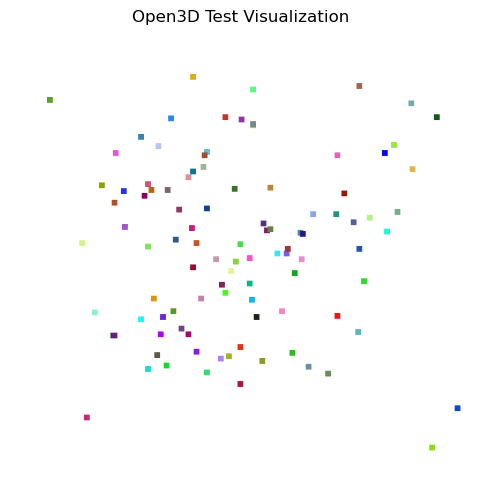

Visualization test successful!


True

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

def test_o3d_visualization():
    """
    Simple test visualization with minimal geometry
    """
    try:
        # Create small random point cloud
        points = np.random.rand(100, 3)  # Just 100 points
        colors = np.random.uniform(0, 1, size=(100, 3))
        
        # Create point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
        # Attempt 1: Simple visualization with screen capture
        vis = o3d.visualization.Visualizer()
        try:
            # Create window with small size
            vis.create_window(visible=True, width=400, height=400)
            vis.add_geometry(pcd)
            
            # Keep window minimal
            ctr = vis.get_view_control()
            ctr.set_zoom(0.8)
            
            # Quick capture and exit
            vis.poll_events()
            vis.update_renderer()
            img = vis.capture_screen_float_buffer(do_render=True)
            vis.destroy_window()
            
            # Display with matplotlib
            plt.figure(figsize=(6,6))
            plt.imshow(np.asarray(img))
            plt.axis('off')
            plt.title('Open3D Test Visualization')
            plt.show()
            
            print("Visualization test successful!")
            return True
            
        except Exception as e:
            print(f"First attempt failed: {str(e)}")
            vis.destroy_window()
            return False
            
    except Exception as e:
        print(f"Error in test visualization: {str(e)}")
        return False

# Run test
print("Starting Open3D visualization test...")
test_o3d_visualization()

In [14]:
import numpy as np
from pathlib import Path
import cv2
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm

class SceneAnalyzer:
    """Analyzes ETH3D scene characteristics to inform matching strategy"""
    
    def __init__(self, scene_path: Path):
        self.scene_path = Path(scene_path)
        self.calibration_path = self.scene_path / 'dslr_calibration_undistorted'
        self.image_path = self.scene_path / 'images' / 'dslr_images_undistorted'
    
    def analyze_camera_positions(self) -> Dict:
        """Analyze camera position distribution and movements"""
        poses = self._load_camera_poses()
        
        # Compute camera-to-camera distances
        positions = np.array([pose['position'] for pose in poses.values()])
        distances = []
        sequential_distances = []
        
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                dist = np.linalg.norm(positions[i] - positions[j])
                distances.append(dist)
                if j == i+1:  # Sequential frames
                    sequential_distances.append(dist)
        
        return {
            'total_images': len(poses),
            'min_distance': np.min(distances),
            'max_distance': np.max(distances),
            'mean_distance': np.mean(distances),
            'sequential_distances': {
                'mean': np.mean(sequential_distances),
                'std': np.std(sequential_distances)
            },
            'positions': positions  # For visualization
        }
    
    def analyze_view_directions(self) -> Dict:
        """Analyze camera viewing directions and overlaps"""
        poses = self._load_camera_poses()
        
        # Convert quaternions to view directions
        directions = []
        sequential_angles = []
        
        for i, pose in enumerate(poses.values()):
            direction = self._quaternion_to_direction(pose['quaternion'])
            directions.append(direction)
            
            if i > 0:
                angle = np.arccos(np.clip(np.dot(directions[-2], direction), -1.0, 1.0))
                sequential_angles.append(angle * 180 / np.pi)  # Convert to degrees
        
        return {
            'sequential_angles': {
                'mean': np.mean(sequential_angles),
                'std': np.std(sequential_angles)
            },
            'directions': np.array(directions)
        }
    
    def visualize_camera_path(self, save_path: Optional[Path] = None):
        """Visualize camera positions and movement pattern"""
        analysis = self.analyze_camera_positions()
        positions = analysis['positions']
        
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot camera positions
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', marker='o')
        
        # Connect sequential positions
        for i in range(len(positions)-1):
            ax.plot([positions[i,0], positions[i+1,0]], 
                   [positions[i,1], positions[i+1,1]], 
                   [positions[i,2], positions[i+1,2]], 'r-')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Camera Positions: {self.scene_path.name}')
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
    
    def _load_camera_poses(self) -> Dict:
        """Load camera poses from ETH3D format"""
        poses = {}
        images_file = self.calibration_path / 'images.txt'
        
        with open(images_file, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                data = line.strip().split()
                if len(data) >= 10:
                    image_name = data[9]
                    poses[image_name] = {
                        'position': np.array([float(x) for x in data[6:9]]),
                        'quaternion': np.array([float(x) for x in data[2:6]])
                    }
        return poses
    
    @staticmethod
    def _quaternion_to_direction(q: np.ndarray) -> np.ndarray:
        """Convert quaternion to view direction vector"""
        w, x, y, z = q
        direction = np.array([
            2 * (x*z + w*y),
            2 * (y*z - w*x),
            1 - 2 * (x*x + y*y)
        ])
        return direction / np.linalg.norm(direction)


Scene: courtyard
Total images: 76
Sequential movement stats:
  Mean distance: 1457.058
  Std distance: 4031.267
Sequential angle changes:
  Mean angle: 95.73°
  Std angle: 19.03°


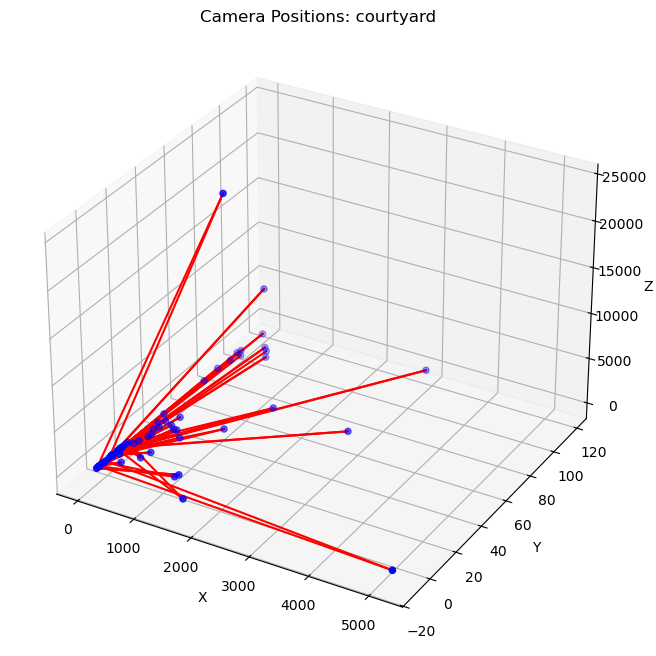


Scene: facade
Total images: 152
Sequential movement stats:
  Mean distance: 19987.769
  Std distance: 40099.496
Sequential angle changes:
  Mean angle: 93.65°
  Std angle: 33.91°


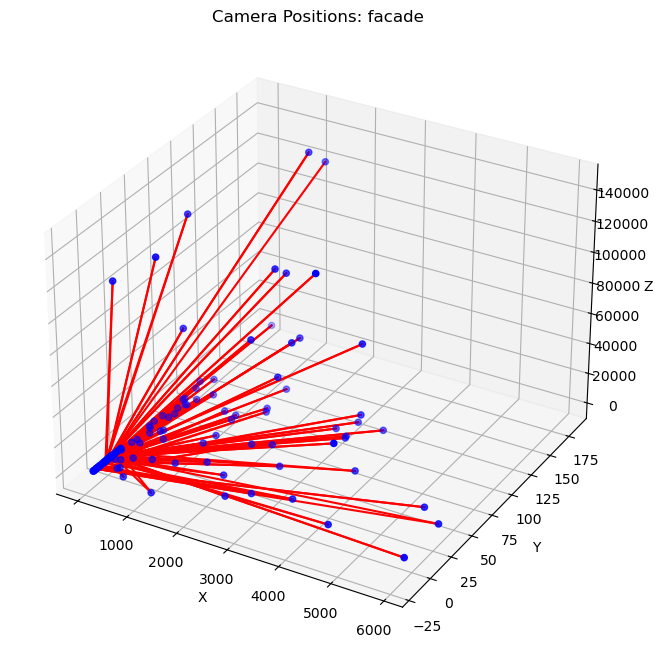


Scene: office
Total images: 52
Sequential movement stats:
  Mean distance: 2451.218
  Std distance: 1308.507
Sequential angle changes:
  Mean angle: 78.58°
  Std angle: 24.38°


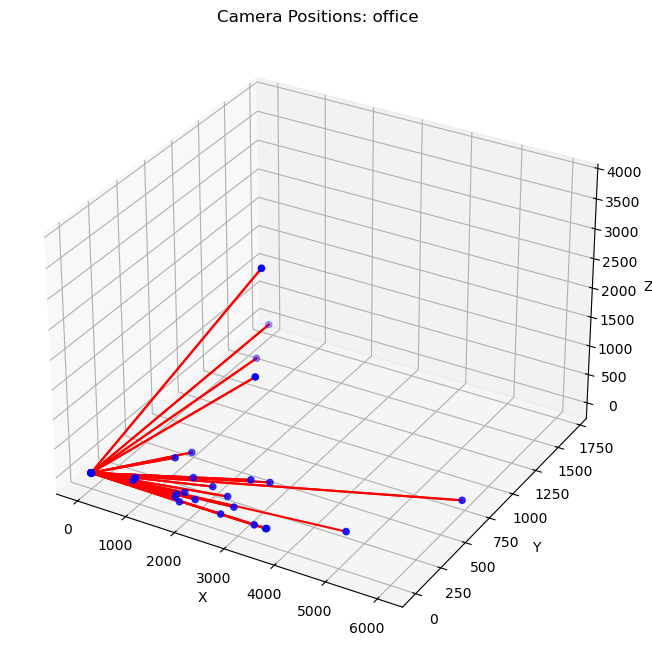


Scene: delivery_area
Total images: 88
Sequential movement stats:
  Mean distance: 1341.784
  Std distance: 4285.708
Sequential angle changes:
  Mean angle: 93.77°
  Std angle: 27.75°


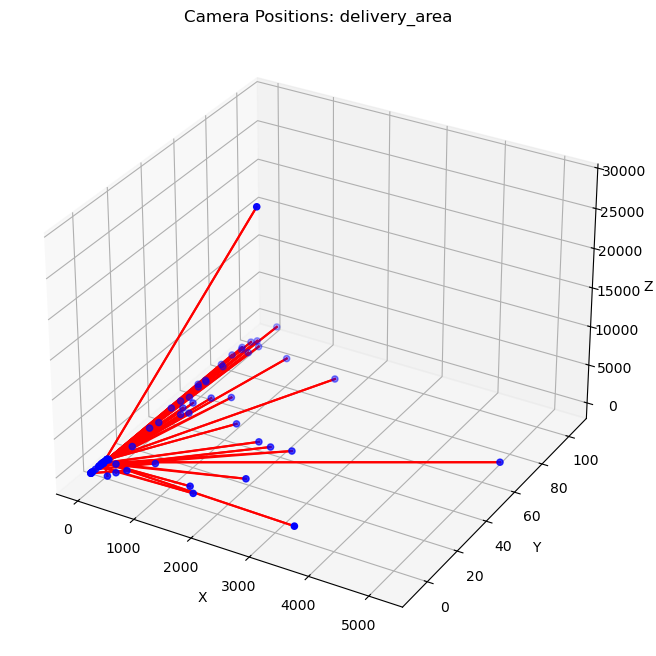


Scene: electro
Total images: 90
Sequential movement stats:
  Mean distance: 2970.151
  Std distance: 3831.830
Sequential angle changes:
  Mean angle: 103.07°
  Std angle: 30.05°


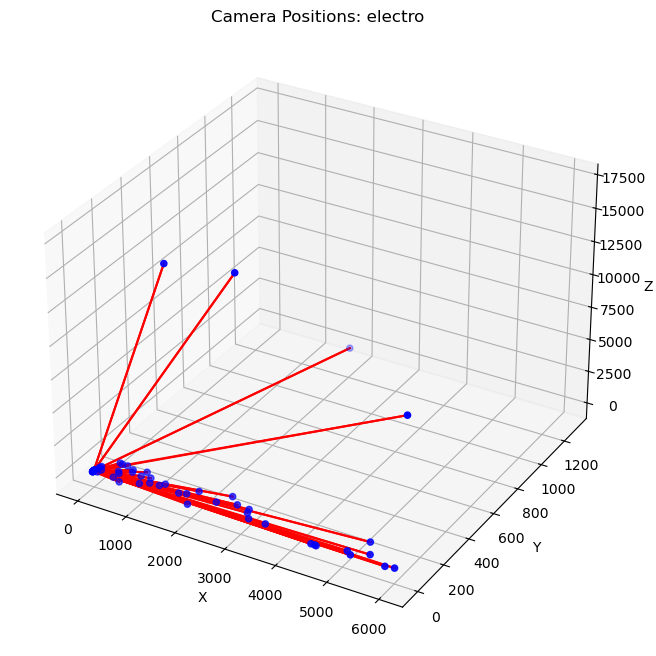


Scene: kicker
Total images: 62
Sequential movement stats:
  Mean distance: 907.692
  Std distance: 1483.475
Sequential angle changes:
  Mean angle: 111.16°
  Std angle: 31.53°


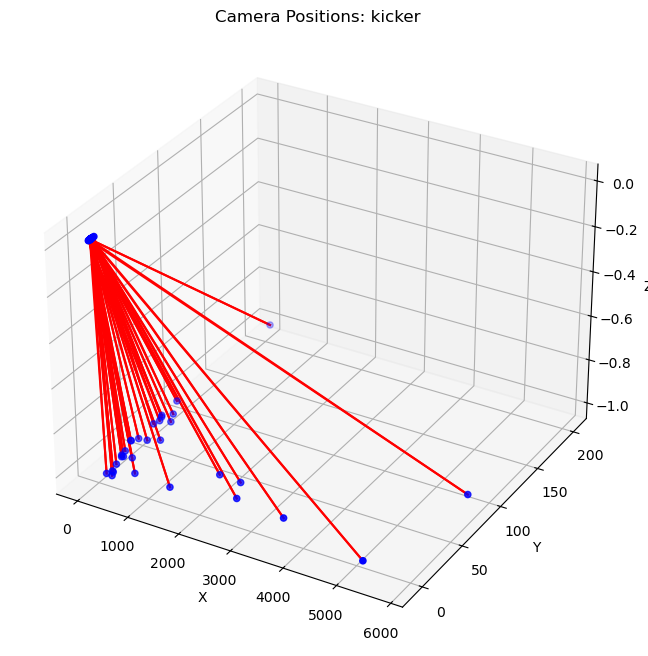


Scene: meadow
Total images: 30
Sequential movement stats:
  Mean distance: 303.702
  Std distance: 781.375
Sequential angle changes:
  Mean angle: 97.32°
  Std angle: 15.20°


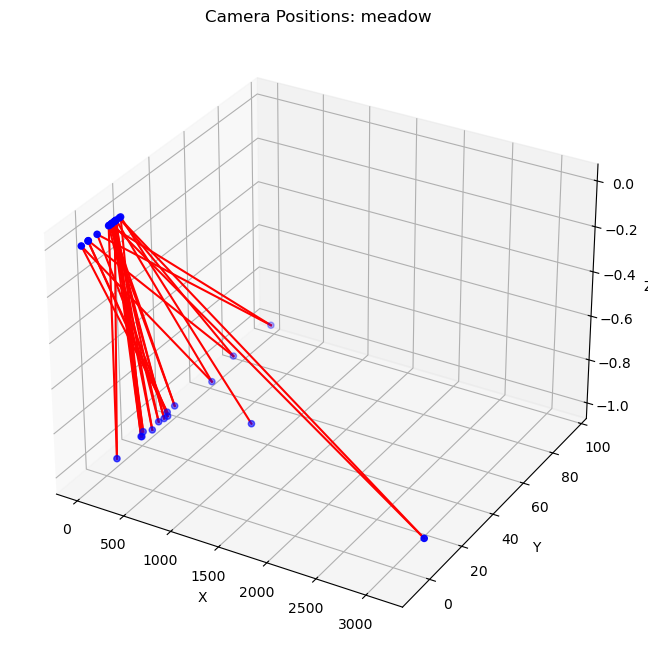


Scene: pipes
Total images: 28
Sequential movement stats:
  Mean distance: 1106.815
  Std distance: 807.811
Sequential angle changes:
  Mean angle: 132.40°
  Std angle: 38.79°


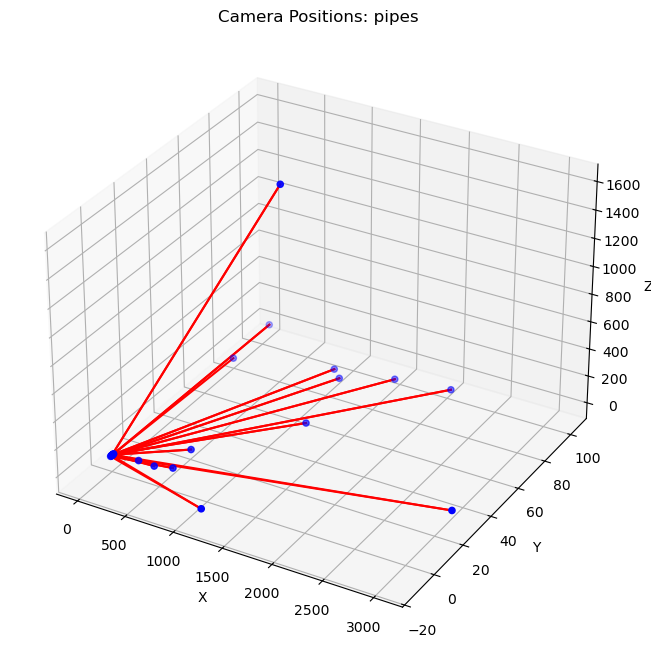


Scene: playground
Total images: 76
Sequential movement stats:
  Mean distance: 2343.940
  Std distance: 3118.180
Sequential angle changes:
  Mean angle: 104.58°
  Std angle: 31.57°


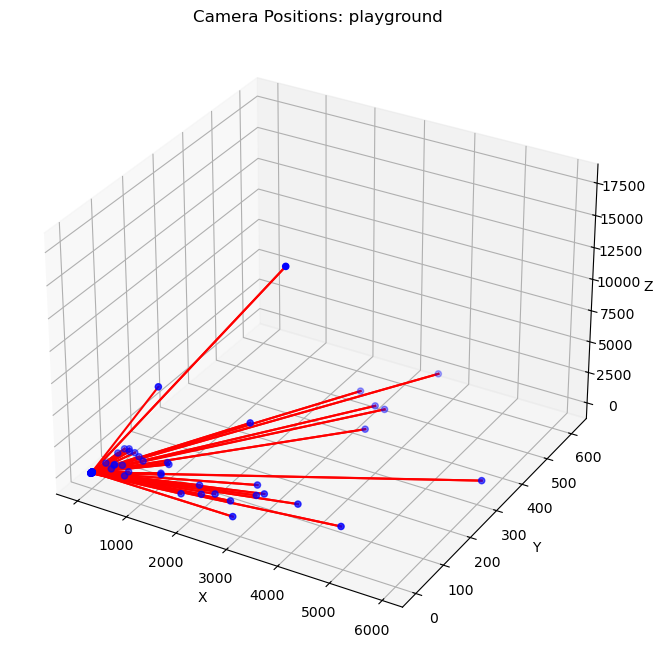


Scene: relief
Total images: 62
Sequential movement stats:
  Mean distance: 3020.067
  Std distance: 4680.846
Sequential angle changes:
  Mean angle: 100.85°
  Std angle: 39.73°


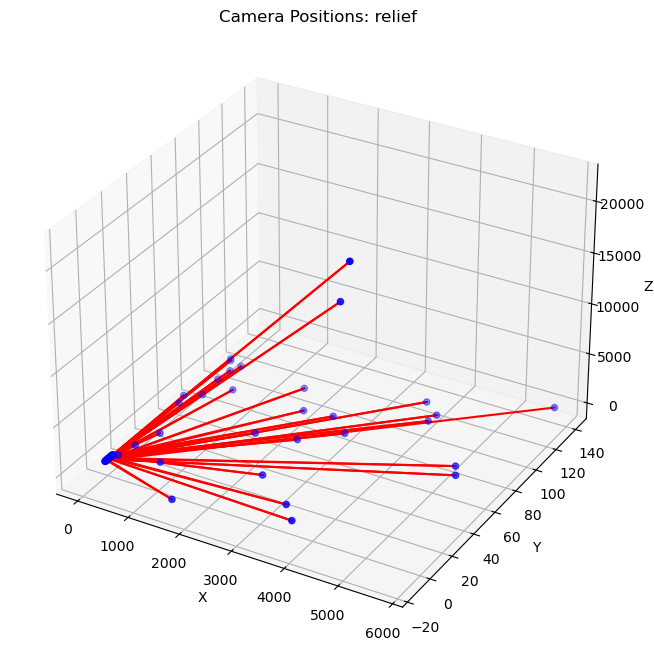


Scene: relief_2
Total images: 62
Sequential movement stats:
  Mean distance: 1634.448
  Std distance: 1720.700
Sequential angle changes:
  Mean angle: 96.88°
  Std angle: 33.52°


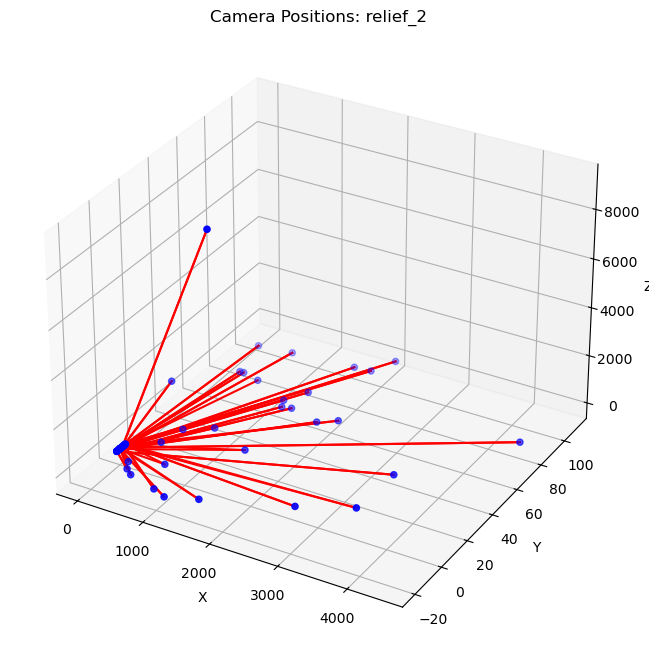


Scene: terrace
Total images: 46
Sequential movement stats:
  Mean distance: 2293.580
  Std distance: 2610.112
Sequential angle changes:
  Mean angle: 96.92°
  Std angle: 30.56°


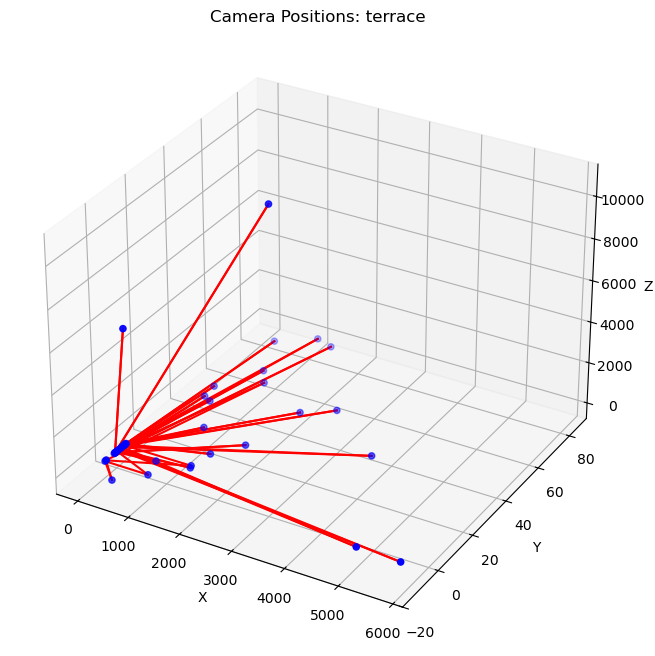


Scene: terrains
Total images: 84
Sequential movement stats:
  Mean distance: 2915.018
  Std distance: 4486.492
Sequential angle changes:
  Mean angle: 83.97°
  Std angle: 32.79°


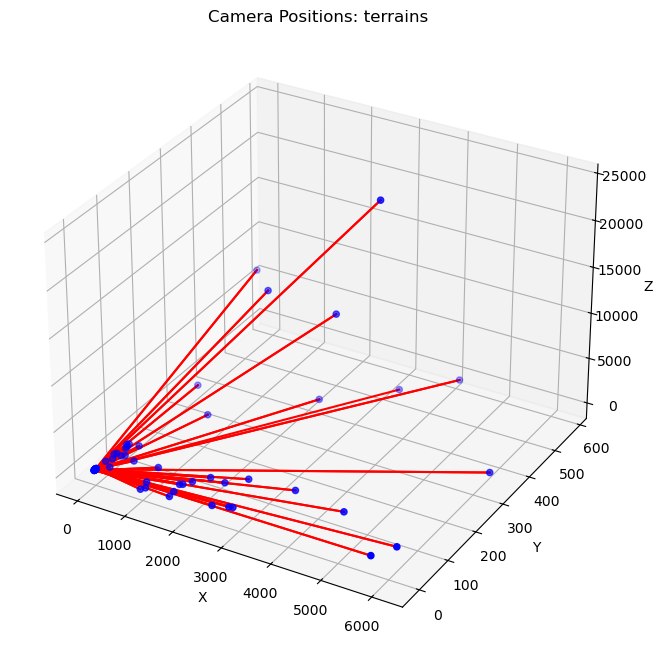

In [15]:

base_path = Path(r"C:\Users\joems\OneDrive\Desktop\MLCV Project Items\Comp Vision CS 5330\CV Project Dataset\mv_undistorted\multi_view_training_dslr_undistorted")
scenes = ['courtyard', 'facade', 'office', 'delivery_area', 'electro', 'kicker', 'meadow', 'pipes', 'playground', 'relief', 'relief_2', 'terrace', 'terrains' ]

for scene_name in scenes:
    scene_path = base_path / scene_name
    analyzer = SceneAnalyzer(scene_path)
    
    # Get position analysis
    pos_stats = analyzer.analyze_camera_positions()
    print(f"\nScene: {scene_name}")
    print(f"Total images: {pos_stats['total_images']}")
    print(f"Sequential movement stats:")
    print(f"  Mean distance: {pos_stats['sequential_distances']['mean']:.3f}")
    print(f"  Std distance: {pos_stats['sequential_distances']['std']:.3f}")
    
    # Get view direction analysis
    view_stats = analyzer.analyze_view_directions()
    print(f"Sequential angle changes:")
    print(f"  Mean angle: {view_stats['sequential_angles']['mean']:.2f}°")
    print(f"  Std angle: {view_stats['sequential_angles']['std']:.2f}°")
    
    # Visualize camera path
    analyzer.visualize_camera_path()

Some Root Cause: 
- DataLoader trying to stack images of different sizes into a batch
- ETH3D dataset images aren't uniformly sized
- PyTorch's default collate function can't handle varying dimensions

Analyzing 38 images...


  0%|          | 0/38 [00:00<?, ?it/s]

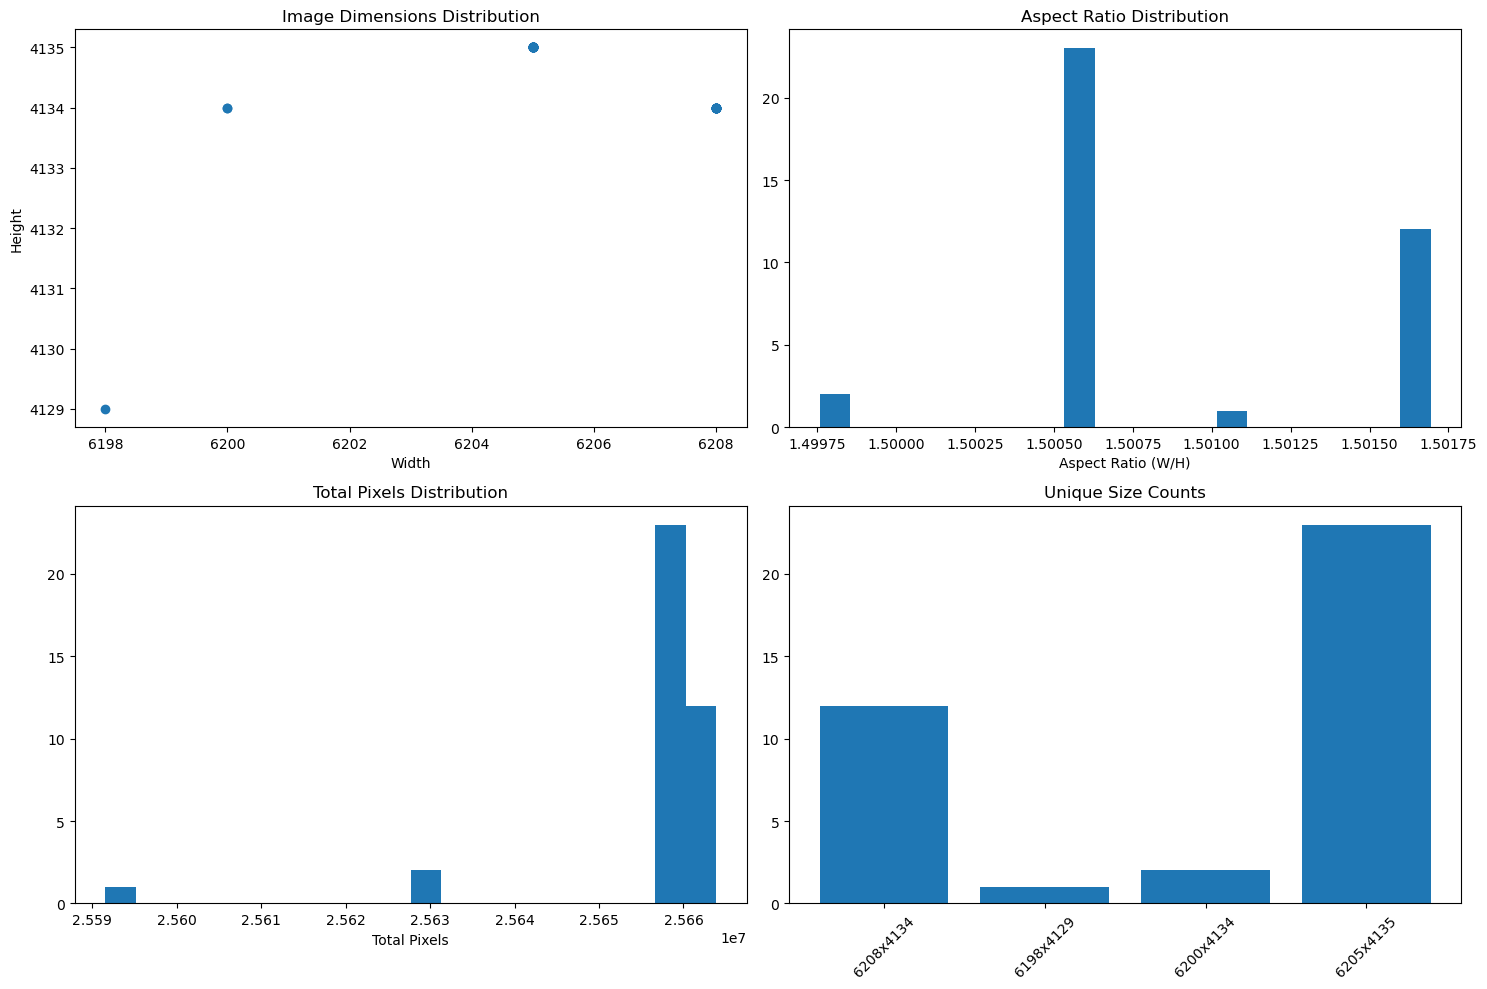


Image Size Statistics:
Number of unique sizes: 4

Most common sizes:
6205x4135: 23 images
6208x4134: 12 images
6200x4134: 2 images

Aspect Ratio: 1.501 ± 0.001


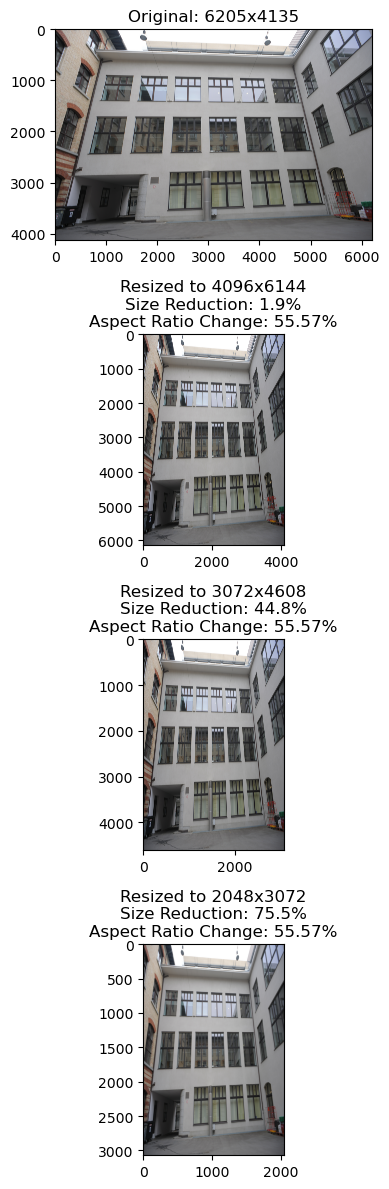

In [2]:
# Script for choosing sizing and more:


import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm

def analyze_image_sizes(scene_path: Path) -> Dict:
    """Analyze image sizes in the dataset"""
    # Find all images
    image_paths = list(scene_path.glob('images/dslr_images_undistorted/*.JPG'))
    
    # Collect size information
    sizes = []
    aspects = []
    total_pixels = []
    
    print(f"Analyzing {len(image_paths)} images...")
    
    for img_path in tqdm(image_paths):
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        sizes.append((h, w))
        aspects.append(w/h)
        total_pixels.append(h*w)
    
    return {
        'sizes': sizes,
        'aspects': aspects,
        'total_pixels': total_pixels,
        'paths': image_paths
    }

def visualize_size_distribution(analysis: Dict):
    """Visualize size distributions"""
    plt.figure(figsize=(15, 10))
    
    # Size distribution
    plt.subplot(221)
    heights = [s[0] for s in analysis['sizes']]
    widths = [s[1] for s in analysis['sizes']]
    plt.scatter(widths, heights)
    plt.title('Image Dimensions Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    
    # Aspect ratio distribution
    plt.subplot(222)
    plt.hist(analysis['aspects'], bins=20)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (W/H)')
    
    # Total pixels distribution
    plt.subplot(223)
    plt.hist(analysis['total_pixels'], bins=20)
    plt.title('Total Pixels Distribution')
    plt.xlabel('Total Pixels')
    
    # Size variation
    plt.subplot(224)
    unique_sizes = set(analysis['sizes'])
    sizes_count = {size: sum(1 for s in analysis['sizes'] if s == size) 
                  for size in unique_sizes}
    
    sizes_list = list(sizes_count.keys())
    counts = list(sizes_count.values())
    plt.bar(range(len(sizes_count)), counts)
    plt.title('Unique Size Counts')
    plt.xticks(range(len(sizes_count)), 
               [f'{s[1]}x{s[0]}' for s in sizes_list], 
               rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nImage Size Statistics:")
    print(f"Number of unique sizes: {len(unique_sizes)}")
    print("\nMost common sizes:")
    for size, count in sorted(sizes_count.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"{size[1]}x{size[0]}: {count} images")
    
    mean_aspect = np.mean(analysis['aspects'])
    std_aspect = np.std(analysis['aspects'])
    print(f"\nAspect Ratio: {mean_aspect:.3f} ± {std_aspect:.3f}")

def analyze_resize_impact(analysis: Dict, target_sizes: List[Tuple[int, int]]):
    """Analyze impact of different resize options"""
    # Select a sample image (middle of dataset)
    sample_path = analysis['paths'][len(analysis['paths'])//2]
    original = cv2.imread(str(sample_path))
    
    plt.figure(figsize=(20, 4*len(target_sizes)))
    plt.subplot(len(target_sizes)+1, 1, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(f'Original: {original.shape[1]}x{original.shape[0]}')
    
    # Test different sizes
    for idx, size in enumerate(target_sizes, 1):
        resized = cv2.resize(original, size, interpolation=cv2.INTER_AREA)
        plt.subplot(len(target_sizes)+1, 1, idx+1)
        plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        
        # Calculate size reduction and aspect ratio change
        orig_aspect = original.shape[1] / original.shape[0]
        new_aspect = size[0] / size[1]
        aspect_change = abs(orig_aspect - new_aspect) / orig_aspect * 100
        size_reduction = (1 - (size[0] * size[1]) / (original.shape[0] * original.shape[1])) * 100
        
        plt.title(f'Resized to {size[0]}x{size[1]}\n'
                 f'Size Reduction: {size_reduction:.1f}%\n'
                 f'Aspect Ratio Change: {aspect_change:.2f}%')
    
    plt.tight_layout()
    plt.show()

# Run analysis
base_path = Path(r"C:\Users\joems\OneDrive\Desktop\MLCV Project Items\Comp Vision CS 5330\CV Project Dataset\mv_undistorted\multi_view_training_dslr_undistorted\courtyard")
analysis = analyze_image_sizes(base_path)
visualize_size_distribution(analysis)

# Test different target sizes
target_sizes = [
    (4096, 6144),  # Maintain high resolution
    (3072, 4608),  # 75% of original
    (2048, 3072)   # 50% of original
]
analyze_resize_impact(analysis, target_sizes)

## SFM PROBLEMS FACED:


## 1. Initial Performance Metrics

    | Metric | Value | Expected Range | Status |
    |--------|-------|----------------|---------|
    | Average Features/Image | 56,331.8 | 1K-50K | ✅ Good |
    | Feature Coverage | 28.47% | >25% | ✅ Good |
    | Track Length Range | 3-9 frames | 3-15 | ⚠️ Limited |
    | Quality Score | 0.93/1.00 | >0.85 | ✅ Good |
    
## 2. Critical Failure Points

### A. Pose Refinement Errors
```plaintext
Camera 1 (DSC_0286.JPG):
- Reprojection Error: inf
- Points Used: 62/124
- All points had errors >10,000 pixels
- Camera matrix det: 11,624,758.435
- Rotation matrix det: 1.000000357

Camera 2 (DSC_0287.JPG):
- Similar infinite errors
- 124 points attempted
- Every point failed reprojection
```

### B. Scale & Transformation Issues

    | Component | Observed | Expected | Problem |
    |-----------|----------|-----------|----------|
    | Point Cloud Scale | 0.426 | ~1.0-10.0 | Too small |
    | Translation Norm | 4.412 | ~10-100 | Scale mismatch |
    | Points Range | [5.44, 4.55, 2.85] | [0.5-2.0] | Too large |
    | Projection Range | [-4073, -4343] | [0-6000] | Sign inversion |
    
## 3. Numerical Analysis

### A. Point Projection Examples
```plaintext
Example Point:
3D Position: [-0.89454665, -4.75957922, 1.22951859]
Camera Frame: [-5.67379639, -5.0581578, 2.6910015]
Expected 2D: (4192.70, 1844.66)
Projected 2D: (-4073.71, -4343.84)
Error: 10,326.24 pixels
```

### B. Camera Matrix Analysis
```python
# Camera Matrix Properties
Original Determinant: 11,624,758.435
Scaling Issues: Values too large for stable computation
Intrinsic Scale: Not properly normalized
```

## 4. Implementation Challenges

### A. Scale-Related Issues
1. **Normalization Problems**
   ```plaintext
   - Points not properly normalized before alignment
   - Scale recovery after alignment failing
   - Scale propagation through transformation chain incorrect
   - Mixed scales between cameras and points
   ```

2. **Numerical Instability**
   ```plaintext
   - Large determinants in camera matrices
   - Incorrect scale propagation
   - Loss of precision in float operations
   - Unstable matrix inversions
   ```

### B. Pose Refinement Failures

    | Stage | Issue | Impact |
    |-------|--------|---------|
    | Point Alignment | Scale mismatch | Poor convergence |
    | Rotation Est. | Determinant ≠ 1 | Invalid transforms |
    | Translation Est. | Wrong scale | Incorrect positions |
    | Reprojection | Infinite errors | No valid poses |

## 5. Error Propagation Chain
        
        ```mermaid
        graph TD
            A[Scale Mismatch] --> B[Poor Point Normalization]
            B --> C[Invalid Camera Poses]
            C --> D[Projection Errors]
            D --> E[Infinite Reprojection]
            E --> F[Failed Refinement]
            F --> G[No Valid Reconstruction]
        ```
        

    Despite strong initial feature extraction and matching:
    - Scale mismatches caused fundamental instability
    - Camera projection chain proved numerically unstable
    - Pose refinement failed consistently
    - Unable to achieve stable reconstruction
    
    The implementation demonstrated that manual SFM is extremely sensitive to:
    - Numerical precision
    - Scale propagation
    - Coordinate system consistency
    - Error accumulation
    
    This analysis suggests that using established SFM libraries (COLMAP, OpenCV) would be more appropriate for reliable reconstruction.
    


**=== ETH3D Dataset Analysis ===**

Directory Structure:
📁 mv_occlusion/
  📁 multi_view_training_dslr_occlusion/
    📁 courtyard/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0286.png (0.03 MB)
          ...
          📄 DSC_0323.png (0.04 MB)
      📁 occlusion/
        📄 splats.ply (8.53 MB)
        📄 surface_mesh.ply (274.09 MB)
    📁 delivery_area/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0677.png (0.03 MB)
          📄 DSC_0678.png (0.03 MB)
          📄 DSC_0679.png (0.03 MB)
          📄 DSC_0680.png (0.03 MB)
          📄 DSC_0681.png (0.03 MB)
          📄 DSC_0682.png (0.04 MB)
          📄 DSC_0683.png (0.04 MB)
          📄 DSC_0684.png (0.04 MB)
          📄 DSC_0685.png (0.05 MB)
          📄 DSC_0686.png (0.05 MB)
          📄 DSC_0687.png (0.05 MB)
          📄 DSC_0688.png (0.05 MB)
          📄 DSC_0689.png (0.05 MB)
          📄 DSC_0690.png (0.06 MB)
          📄 DSC_0691.png (0.07 MB)
          📄 DSC_0692.png (0.06 MB)
          📄 DSC_0693.png (0.05 MB)
          📄 DSC_0694.png (0.04 MB)
          📄 DSC_0695.png (0.04 MB)
          📄 DSC_0696.png (0.04 MB)
          📄 DSC_0697.png (0.05 MB)
          📄 DSC_0698.png (0.05 MB)
          📄 DSC_0699.png (0.05 MB)
          📄 DSC_0700.png (0.05 MB)
          📄 DSC_0701.png (0.05 MB)
          📄 DSC_0702.png (0.05 MB)
          📄 DSC_0703.png (0.04 MB)
          📄 DSC_0704.png (0.04 MB)
          📄 DSC_0705.png (0.04 MB)
          📄 DSC_0706.png (0.03 MB)
          📄 DSC_0707.png (0.03 MB)
          📄 DSC_0708.png (0.03 MB)
          📄 DSC_0709.png (0.04 MB)
          📄 DSC_0710.png (0.05 MB)
          📄 DSC_0711.png (0.06 MB)
          📄 DSC_0712.png (0.07 MB)
          📄 DSC_0713.png (0.07 MB)
          📄 DSC_0714.png (0.07 MB)
          📄 DSC_0715.png (0.04 MB)
          📄 DSC_0716.png (0.06 MB)
          📄 DSC_0717.png (0.06 MB)
          📄 DSC_0718.png (0.06 MB)
      📁 occlusion/
        📄 splats.ply (17.91 MB)
        📄 surface_mesh.ply (95.18 MB)
    📁 electro/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_9257.png (0.06 MB)
          📄 DSC_9258.png (0.07 MB)
          📄 DSC_9259.png (0.11 MB)
          📄 DSC_9260.png (0.05 MB)
          📄 DSC_9261.png (0.05 MB)
          📄 DSC_9262.png (0.03 MB)
          📄 DSC_9263.png (0.04 MB)
          📄 DSC_9264.png (0.05 MB)
          📄 DSC_9265.png (0.04 MB)
          📄 DSC_9266.png (0.04 MB)
          📄 DSC_9267.png (0.04 MB)
          📄 DSC_9268.png (0.06 MB)
          📄 DSC_9269.png (0.06 MB)
          📄 DSC_9270.png (0.07 MB)
          📄 DSC_9271.png (0.08 MB)
          📄 DSC_9272.png (0.10 MB)
          📄 DSC_9273.png (0.06 MB)
          📄 DSC_9274.png (0.08 MB)
          📄 DSC_9275.png (0.03 MB)
          📄 DSC_9276.png (0.03 MB)
          📄 DSC_9277.png (0.05 MB)
          📄 DSC_9278.png (0.04 MB)
          📄 DSC_9279.png (0.05 MB)
          📄 DSC_9280.png (0.04 MB)
          📄 DSC_9281.png (0.05 MB)
          📄 DSC_9283.png (0.07 MB)
          📄 DSC_9284.png (0.05 MB)
          📄 DSC_9285.png (0.04 MB)
          📄 DSC_9286.png (0.04 MB)
          📄 DSC_9287.png (0.05 MB)
          📄 DSC_9293.png (0.05 MB)
          📄 DSC_9294.png (0.08 MB)
          📄 DSC_9295.png (0.10 MB)
          📄 DSC_9296.png (0.17 MB)
          📄 DSC_9297.png (0.17 MB)
          📄 DSC_9299.png (0.08 MB)
          📄 DSC_9300.png (0.10 MB)
          📄 DSC_9301.png (0.14 MB)
          📄 DSC_9302.png (0.07 MB)
          📄 DSC_9303.png (0.07 MB)
      📁 occlusion/
        📄 splats.ply (35.18 MB)
        📄 surface_mesh.ply (61.10 MB)
    📁 facade/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0324.png (0.04 MB)
          📄 DSC_0325.png (0.04 MB)
          📄 DSC_0326.png (0.04 MB)
          📄 DSC_0327.png (0.08 MB)
          📄 DSC_0328.png (0.08 MB)
          📄 DSC_0329.png (0.08 MB)
          📄 DSC_0330.png (0.09 MB)
          📄 DSC_0331.png (0.08 MB)
          📄 DSC_0332.png (0.09 MB)
          📄 DSC_0333.png (0.10 MB)
          📄 DSC_0334.png (0.10 MB)
          📄 DSC_0335.png (0.09 MB)
          📄 DSC_0336.png (0.10 MB)
          📄 DSC_0337.png (0.11 MB)
          📄 DSC_0338.png (0.10 MB)
          📄 DSC_0339.png (0.10 MB)
          📄 DSC_0340.png (0.08 MB)
          📄 DSC_0341.png (0.09 MB)
          📄 DSC_0342.png (0.10 MB)
          📄 DSC_0343.png (0.10 MB)
          📄 DSC_0344.png (0.10 MB)
          📄 DSC_0345.png (0.10 MB)
          📄 DSC_0346.png (0.10 MB)
          📄 DSC_0347.png (0.11 MB)
          📄 DSC_0348.png (0.10 MB)
          📄 DSC_0349.png (0.10 MB)
          📄 DSC_0350.png (0.10 MB)
          📄 DSC_0351.png (0.10 MB)
          📄 DSC_0352.png (0.11 MB)
          📄 DSC_0353.png (0.09 MB)
          📄 DSC_0354.png (0.08 MB)
          📄 DSC_0355.png (0.10 MB)
          📄 DSC_0356.png (0.10 MB)
          📄 DSC_0357.png (0.11 MB)
          📄 DSC_0358.png (0.10 MB)
          📄 DSC_0359.png (0.08 MB)
          📄 DSC_0360.png (0.06 MB)
          📄 DSC_0361.png (0.04 MB)
          📄 DSC_0362.png (0.04 MB)
          📄 DSC_0363.png (0.04 MB)
          📄 DSC_0364.png (0.05 MB)
          📄 DSC_0365.png (0.04 MB)
          📄 DSC_0366.png (0.04 MB)
          📄 DSC_0386.png (0.07 MB)
          📄 DSC_0387.png (0.06 MB)
          📄 DSC_0388.png (0.08 MB)
          📄 DSC_0389.png (0.09 MB)
          📄 DSC_0390.png (0.06 MB)
          📄 DSC_0391.png (0.06 MB)
          📄 DSC_0392.png (0.08 MB)
          📄 DSC_0393.png (0.08 MB)
          📄 DSC_0394.png (0.06 MB)
          📄 DSC_0395.png (0.10 MB)
          📄 DSC_0396.png (0.14 MB)
          📄 DSC_0397.png (0.11 MB)
          📄 DSC_0398.png (0.11 MB)
          📄 DSC_0399.png (0.11 MB)
          📄 DSC_0400.png (0.11 MB)
          📄 DSC_0401.png (0.15 MB)
          📄 DSC_0402.png (0.12 MB)
          📄 DSC_0404.png (0.12 MB)
          📄 DSC_0405.png (0.13 MB)
          📄 DSC_0406.png (0.13 MB)
          📄 DSC_0407.png (0.14 MB)
          📄 DSC_0408.png (0.12 MB)
          📄 DSC_0409.png (0.12 MB)
          📄 DSC_0410.png (0.12 MB)
          📄 DSC_0411.png (0.11 MB)
          📄 DSC_0412.png (0.09 MB)
          📄 DSC_0413.png (0.09 MB)
          📄 DSC_0414.png (0.09 MB)
          📄 DSC_0415.png (0.09 MB)
          📄 DSC_0416.png (0.06 MB)
          📄 DSC_0417.png (0.05 MB)
          📄 DSC_0418.png (0.04 MB)
          📄 DSC_0419.png (0.04 MB)
          📄 DSC_0420.png (0.04 MB)
          📄 DSC_0421.png (0.07 MB)
          📄 DSC_0422.png (0.07 MB)
      📁 occlusion/
        📄 splats.ply (252.38 MB)
        📄 surface_mesh.ply (57.68 MB)
    📁 kicker/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_6487.png (0.03 MB)
          📄 DSC_6488.png (0.03 MB)
          📄 DSC_6489.png (0.05 MB)
          📄 DSC_6490.png (0.04 MB)
          📄 DSC_6491.png (0.05 MB)
          📄 DSC_6492.png (0.04 MB)
          📄 DSC_6493.png (0.04 MB)
          📄 DSC_6494.png (0.04 MB)
          📄 DSC_6495.png (0.04 MB)
          📄 DSC_6496.png (0.04 MB)
          📄 DSC_6497.png (0.03 MB)
          📄 DSC_6499.png (0.04 MB)
          📄 DSC_6500.png (0.05 MB)
          📄 DSC_6501.png (0.03 MB)
          📄 DSC_6502.png (0.04 MB)
          📄 DSC_6503.png (0.05 MB)
          📄 DSC_6504.png (0.05 MB)
          📄 DSC_6505.png (0.04 MB)
          📄 DSC_6506.png (0.05 MB)
          📄 DSC_6507.png (0.03 MB)
          📄 DSC_6508.png (0.04 MB)
          📄 DSC_6509.png (0.05 MB)
          📄 DSC_6510.png (0.04 MB)
          📄 DSC_6511.png (0.03 MB)
          📄 DSC_6512.png (0.03 MB)
          📄 DSC_6513.png (0.04 MB)
          📄 DSC_6514.png (0.03 MB)
          📄 DSC_6515.png (0.04 MB)
          📄 DSC_6516.png (0.05 MB)
          📄 DSC_6517.png (0.04 MB)
          📄 DSC_6518.png (0.04 MB)
          📄 DSC_6519.png (0.03 MB)
          📄 DSC_6520.png (0.03 MB)
      📁 occlusion/
        📄 splats.ply (0.37 MB)
        📄 surface_mesh.ply (274.18 MB)
    📁 meadow/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_6535.png (0.06 MB)
          📄 DSC_6536.png (0.04 MB)
          📄 DSC_6537.png (0.04 MB)
          📄 DSC_6538.png (0.04 MB)
          📄 DSC_6539.png (0.04 MB)
          📄 DSC_6540.png (0.03 MB)
          📄 DSC_6547.png (0.04 MB)
          📄 DSC_6548.png (0.04 MB)
          📄 DSC_6553.png (0.05 MB)
          📄 DSC_6554.png (0.04 MB)
          📄 DSC_6555.png (0.04 MB)
          📄 DSC_6556.png (0.04 MB)
          📄 DSC_6557.png (0.04 MB)
          📄 DSC_6558.png (0.04 MB)
          📄 DSC_6559.png (0.06 MB)
          📄 DSC_6560.png (0.04 MB)
      📁 occlusion/
        📄 splats.ply (152.15 MB)
        📄 surface_mesh.ply (131.70 MB)
    📁 office/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0219.png (0.04 MB)
          📄 DSC_0220.png (0.04 MB)
          📄 DSC_0221.png (0.04 MB)
          📄 DSC_0222.png (0.03 MB)
          📄 DSC_0223.png (0.03 MB)
          📄 DSC_0228.png (0.03 MB)
          📄 DSC_0229.png (0.04 MB)
          📄 DSC_0230.png (0.04 MB)
          📄 DSC_0231.png (0.04 MB)
          📄 DSC_0235.png (0.03 MB)
          📄 DSC_0236.png (0.03 MB)
          📄 DSC_0237.png (0.04 MB)
          📄 DSC_0238.png (0.04 MB)
          📄 DSC_0239.png (0.04 MB)
          📄 DSC_0240.png (0.03 MB)
          📄 DSC_0241.png (0.03 MB)
          📄 DSC_0242.png (0.04 MB)
          📄 DSC_0243.png (0.04 MB)
          📄 DSC_0248.png (0.04 MB)
          📄 DSC_0249.png (0.04 MB)
          📄 DSC_0250.png (0.05 MB)
          📄 DSC_0251.png (0.04 MB)
          📄 DSC_0252.png (0.04 MB)
          📄 DSC_0253.png (0.04 MB)
          📄 DSC_0254.png (0.04 MB)
          📄 DSC_0255.png (0.04 MB)
      📁 occlusion/
        📄 splats.ply (0.01 MB)
        📄 surface_mesh.ply (577.42 MB)
    📁 pipes/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0634.png (0.04 MB)
          📄 DSC_0635.png (0.03 MB)
          📄 DSC_0636.png (0.04 MB)
          📄 DSC_0637.png (0.03 MB)
          📄 DSC_0638.png (0.03 MB)
          📄 DSC_0639.png (0.04 MB)
          📄 DSC_0640.png (0.04 MB)
          📄 DSC_0641.png (0.04 MB)
          📄 DSC_0642.png (0.04 MB)
          📄 DSC_0643.png (0.04 MB)
          📄 DSC_0644.png (0.04 MB)
          📄 DSC_0645.png (0.03 MB)
          📄 DSC_0646.png (0.04 MB)
          📄 DSC_0647.png (0.04 MB)
      📁 occlusion/
        📄 splats.ply (1.11 MB)
        📄 surface_mesh.ply (119.53 MB)
    📁 playground/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0567.png (0.06 MB)
          📄 DSC_0568.png (0.06 MB)
          📄 DSC_0569.png (0.07 MB)
          📄 DSC_0570.png (0.06 MB)
          📄 DSC_0571.png (0.07 MB)
          📄 DSC_0572.png (0.07 MB)
          📄 DSC_0573.png (0.07 MB)
          📄 DSC_0574.png (0.04 MB)
          📄 DSC_0575.png (0.04 MB)
          📄 DSC_0576.png (0.04 MB)
          📄 DSC_0577.png (0.04 MB)
          📄 DSC_0578.png (0.03 MB)
          📄 DSC_0579.png (0.03 MB)
          📄 DSC_0580.png (0.05 MB)
          📄 DSC_0581.png (0.05 MB)
          📄 DSC_0582.png (0.07 MB)
          📄 DSC_0583.png (0.06 MB)
          📄 DSC_0584.png (0.06 MB)
          📄 DSC_0585.png (0.06 MB)
          📄 DSC_0586.png (0.06 MB)
          📄 DSC_0587.png (0.03 MB)
          📄 DSC_0588.png (0.04 MB)
          📄 DSC_0589.png (0.03 MB)
          📄 DSC_0590.png (0.04 MB)
          📄 DSC_0591.png (0.03 MB)
          📄 DSC_0592.png (0.03 MB)
          📄 DSC_0593.png (0.07 MB)
          📄 DSC_0594.png (0.06 MB)
          📄 DSC_0595.png (0.07 MB)
          📄 DSC_0596.png (0.06 MB)
          📄 DSC_0597.png (0.07 MB)
          📄 DSC_0598.png (0.04 MB)
          📄 DSC_0599.png (0.07 MB)
          📄 DSC_0600.png (0.05 MB)
          📄 DSC_0601.png (0.06 MB)
          📄 DSC_0602.png (0.07 MB)
          📄 DSC_0603.png (0.07 MB)
          📄 DSC_0604.png (0.07 MB)
          📄 DSC_0605.png (0.06 MB)
          📄 DSC_0606.png (0.08 MB)
      📁 occlusion/
        📄 splats.ply (83.79 MB)
        📄 surface_mesh.ply (120.64 MB)
    📁 relief/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0427.png (0.03 MB)
          📄 DSC_0428.png (0.03 MB)
          📄 DSC_0429.png (0.03 MB)
          📄 DSC_0430.png (0.03 MB)
          📄 DSC_0431.png (0.03 MB)
          📄 DSC_0432.png (0.03 MB)
          📄 DSC_0433.png (0.03 MB)
          📄 DSC_0434.png (0.03 MB)
          📄 DSC_0435.png (0.03 MB)
          📄 DSC_0436.png (0.03 MB)
          📄 DSC_0437.png (0.03 MB)
          📄 DSC_0438.png (0.03 MB)
          📄 DSC_0439.png (0.03 MB)
          📄 DSC_0440.png (0.03 MB)
          📄 DSC_0441.png (0.04 MB)
          📄 DSC_0442.png (0.03 MB)
          📄 DSC_0443.png (0.03 MB)
          📄 DSC_0444.png (0.03 MB)
          📄 DSC_0445.png (0.04 MB)
          📄 DSC_0446.png (0.04 MB)
          📄 DSC_0447.png (0.04 MB)
          📄 DSC_0448.png (0.04 MB)
          📄 DSC_0449.png (0.05 MB)
          📄 DSC_0450.png (0.05 MB)
          📄 DSC_0451.png (0.05 MB)
          📄 DSC_0453.png (0.03 MB)
          📄 DSC_0454.png (0.03 MB)
          📄 DSC_0455.png (0.04 MB)
          📄 DSC_0456.png (0.03 MB)
          📄 DSC_0457.png (0.03 MB)
      📁 occlusion/
        📄 splats.ply (34.70 MB)
        📄 surface_mesh.ply (48.92 MB)
    📁 relief_2/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0458.png (0.03 MB)
          📄 DSC_0459.png (0.03 MB)
          📄 DSC_0460.png (0.03 MB)
          📄 DSC_0461.png (0.03 MB)
          📄 DSC_0462.png (0.03 MB)
          📄 DSC_0463.png (0.03 MB)
          📄 DSC_0464.png (0.03 MB)
          📄 DSC_0465.png (0.03 MB)
          📄 DSC_0466.png (0.03 MB)
          📄 DSC_0467.png (0.03 MB)
          📄 DSC_0468.png (0.03 MB)
          📄 DSC_0469.png (0.03 MB)
          📄 DSC_0470.png (0.03 MB)
          📄 DSC_0471.png (0.03 MB)
          📄 DSC_0472.png (0.04 MB)
          📄 DSC_0473.png (0.04 MB)
          📄 DSC_0474.png (0.05 MB)
          📄 DSC_0475.png (0.05 MB)
          📄 DSC_0476.png (0.05 MB)
          📄 DSC_0477.png (0.05 MB)
          📄 DSC_0478.png (0.05 MB)
          📄 DSC_0479.png (0.04 MB)
          📄 DSC_0480.png (0.05 MB)
          📄 DSC_0482.png (0.03 MB)
          📄 DSC_0483.png (0.03 MB)
          📄 DSC_0484.png (0.03 MB)
          📄 DSC_0485.png (0.03 MB)
          📄 DSC_0486.png (0.03 MB)
          📄 DSC_0487.png (0.03 MB)
          📄 DSC_0488.png (0.03 MB)
          📄 DSC_0489.png (0.03 MB)
      📁 occlusion/
        📄 splats.ply (24.48 MB)
        📄 surface_mesh.ply (51.06 MB)
    📁 terrace/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0259.png (0.05 MB)
          📄 DSC_0260.png (0.05 MB)
          📄 DSC_0261.png (0.06 MB)
          📄 DSC_0262.png (0.05 MB)
          📄 DSC_0263.png (0.06 MB)
          📄 DSC_0264.png (0.04 MB)
          📄 DSC_0265.png (0.04 MB)
          📄 DSC_0266.png (0.04 MB)
          📄 DSC_0267.png (0.03 MB)
          📄 DSC_0268.png (0.03 MB)
          📄 DSC_0269.png (0.03 MB)
          📄 DSC_0270.png (0.03 MB)
          📄 DSC_0271.png (0.03 MB)
          📄 DSC_0272.png (0.03 MB)
          📄 DSC_0273.png (0.03 MB)
          📄 DSC_0274.png (0.03 MB)
          📄 DSC_0275.png (0.03 MB)
          📄 DSC_0276.png (0.03 MB)
          📄 DSC_0277.png (0.03 MB)
          📄 DSC_0278.png (0.04 MB)
          📄 DSC_0279.png (0.04 MB)
          📄 DSC_0280.png (0.03 MB)
          📄 DSC_0281.png (0.03 MB)
          📄 DSC_0282.png (0.03 MB)
          📄 DSC_0284.png (0.04 MB)
          📄 DSC_0285.png (0.04 MB)
      📁 occlusion/
        📄 splats.ply (95.65 MB)
        📄 surface_mesh.ply (25.82 MB)
    📁 terrains/
      📁 masks_for_images/
        📁 dslr_images/
          📄 DSC_0614.png (0.03 MB)
          📄 DSC_0615.png (0.03 MB)
          📄 DSC_0616.png (0.03 MB)
          📄 DSC_0617.png (0.03 MB)
          📄 DSC_0618.png (0.03 MB)
          📄 DSC_0619.png (0.03 MB)
          📄 DSC_0620.png (0.04 MB)
          📄 DSC_0622.png (0.04 MB)
          📄 DSC_0623.png (0.04 MB)
          📄 DSC_0624.png (0.04 MB)
          📄 DSC_0625.png (0.04 MB)
          📄 DSC_0626.png (0.04 MB)
          📄 DSC_0627.png (0.04 MB)
          📄 DSC_0628.png (0.04 MB)
          📄 DSC_0629.png (0.03 MB)
          📄 DSC_0630.png (0.03 MB)
          📄 DSC_0631.png (0.03 MB)
          📄 DSC_0632.png (0.03 MB)
          📄 DSC_0648.png (0.05 MB)
          📄 DSC_0649.png (0.05 MB)
          📄 DSC_0650.png (0.05 MB)
          📄 DSC_0651.png (0.05 MB)
          📄 DSC_0652.png (0.05 MB)
          📄 DSC_0653.png (0.04 MB)
          📄 DSC_0654.png (0.06 MB)
          📄 DSC_0655.png (0.06 MB)
          📄 DSC_0656.png (0.05 MB)
          📄 DSC_0657.png (0.05 MB)
          📄 DSC_0658.png (0.05 MB)
          📄 DSC_0659.png (0.05 MB)
          📄 DSC_0660.png (0.04 MB)
          📄 DSC_0661.png (0.04 MB)
          📄 DSC_0662.png (0.04 MB)
          📄 DSC_0663.png (0.04 MB)
          📄 DSC_0664.png (0.05 MB)
          📄 DSC_0665.png (0.05 MB)
          📄 DSC_0666.png (0.06 MB)
          📄 DSC_0667.png (0.06 MB)
          📄 DSC_0668.png (0.06 MB)
          📄 DSC_0669.png (0.06 MB)
          📄 DSC_0670.png (0.05 MB)
          📄 DSC_0671.png (0.05 MB)
      📁 occlusion/
        📄 splats.ply (1.37 MB)
        📄 surface_mesh.ply (94.34 MB)
📁 mv_scan_eval/
  📁 multi_view_training_dslr_scan_eval/
    📁 courtyard/
      📁 dslr_scan_eval/
        📄 scan1.ply (194.14 MB)
        📄 scan2.ply (200.16 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 delivery_area/
      📁 dslr_scan_eval/
        📄 scan1.ply (106.58 MB)
        📄 scan2.ply (178.36 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 electro/
      📁 dslr_scan_eval/
        📄 scan1.ply (153.31 MB)
        📄 scan2.ply (132.90 MB)
        📄 scan3.ply (127.17 MB)
        📄 scan4.ply (140.34 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 facade/
      📁 dslr_scan_eval/
        📄 scan1.ply (138.73 MB)
        📄 scan2.ply (135.65 MB)
        📄 scan3.ply (97.02 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 kicker/
      📁 dslr_scan_eval/
        📄 scan1.ply (256.62 MB)
        📄 scan2.ply (252.52 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 meadow/
      📁 dslr_scan_eval/
        📄 scan1.ply (71.53 MB)
        📄 scan2.ply (92.61 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 office/
      📁 dslr_scan_eval/
        📄 scan1.ply (214.42 MB)
        📄 scan2.ply (227.00 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 pipes/
      📁 dslr_scan_eval/
        📄 scan1.ply (131.41 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 playground/
      📁 dslr_scan_eval/
        📄 scan1.ply (96.87 MB)
        📄 scan2.ply (92.48 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 relief/
      📁 dslr_scan_eval/
        📄 scan1.ply (211.01 MB)
        📄 scan2.ply (186.98 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 relief_2/
      📁 dslr_scan_eval/
        📄 scan1.ply (210.85 MB)
        📄 scan2.ply (188.32 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 terrace/
      📁 dslr_scan_eval/
        📄 scan1.ply (225.35 MB)
        📄 scan2.ply (143.88 MB)
        📄 scan_alignment.mlp (0.00 MB)
    📁 terrains/
      📁 dslr_scan_eval/
        📄 scan1.ply (191.71 MB)
        📄 scan2.ply (189.88 MB)
        📄 scan_alignment.mlp (0.00 MB)
📁 mv_undistorted/
  📁 multi_view_training_dslr_undistorted/
    📁 courtyard/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (6.82 MB)
        📄 points3D.txt (2.63 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0286.JPG (11.24 MB)
          📄 DSC_0287.JPG (11.46 MB)
          📄 DSC_0288.JPG (11.60 MB)
          📄 DSC_0289.JPG (11.56 MB)
          📄 DSC_0290.JPG (11.51 MB)
          📄 DSC_0291.JPG (11.51 MB)
          📄 DSC_0292.JPG (11.46 MB)
          📄 DSC_0293.JPG (11.50 MB)
          📄 DSC_0294.JPG (11.50 MB)
          📄 DSC_0295.JPG (11.54 MB)
          📄 DSC_0296.JPG (11.51 MB)
          📄 DSC_0297.JPG (11.30 MB)
          📄 DSC_0298.JPG (11.14 MB)
          📄 DSC_0299.JPG (11.70 MB)
          📄 DSC_0300.JPG (11.45 MB)
          📄 DSC_0301.JPG (11.00 MB)
          📄 DSC_0302.JPG (12.85 MB)
          📄 DSC_0303.JPG (12.20 MB)
          📄 DSC_0304.JPG (11.85 MB)
          📄 DSC_0305.JPG (11.46 MB)
          📄 DSC_0306.JPG (11.89 MB)
          📄 DSC_0307.JPG (12.05 MB)
          📄 DSC_0308.JPG (12.39 MB)
          📄 DSC_0309.JPG (12.77 MB)
          📄 DSC_0310.JPG (11.94 MB)
          📄 DSC_0311.JPG (13.98 MB)
          📄 DSC_0312.JPG (14.58 MB)
          📄 DSC_0313.JPG (14.83 MB)
          📄 DSC_0314.JPG (15.59 MB)
          📄 DSC_0315.JPG (13.92 MB)
          📄 DSC_0316.JPG (13.46 MB)
          📄 DSC_0317.JPG (13.61 MB)
          📄 DSC_0318.JPG (14.01 MB)
          📄 DSC_0319.JPG (15.52 MB)
          📄 DSC_0320.JPG (14.26 MB)
          📄 DSC_0321.JPG (13.77 MB)
          📄 DSC_0322.JPG (13.98 MB)
          📄 DSC_0323.JPG (13.70 MB)
    📁 delivery_area/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (5.81 MB)
        📄 points3D.txt (2.37 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0675.JPG (8.89 MB)
          📄 DSC_0676.JPG (8.98 MB)
          📄 DSC_0677.JPG (8.98 MB)
          📄 DSC_0678.JPG (9.11 MB)
          📄 DSC_0679.JPG (9.37 MB)
          📄 DSC_0680.JPG (9.40 MB)
          📄 DSC_0681.JPG (9.70 MB)
          📄 DSC_0682.JPG (10.98 MB)
          📄 DSC_0683.JPG (11.13 MB)
          📄 DSC_0684.JPG (10.97 MB)
          📄 DSC_0685.JPG (11.29 MB)
          📄 DSC_0686.JPG (11.45 MB)
          📄 DSC_0687.JPG (11.33 MB)
          📄 DSC_0688.JPG (11.37 MB)
          📄 DSC_0689.JPG (11.37 MB)
          📄 DSC_0690.JPG (11.12 MB)
          📄 DSC_0691.JPG (10.85 MB)
          📄 DSC_0692.JPG (10.49 MB)
          📄 DSC_0693.JPG (10.14 MB)
          📄 DSC_0694.JPG (10.43 MB)
          📄 DSC_0695.JPG (10.45 MB)
          📄 DSC_0696.JPG (10.52 MB)
          📄 DSC_0697.JPG (10.80 MB)
          📄 DSC_0698.JPG (10.67 MB)
          📄 DSC_0699.JPG (10.56 MB)
          📄 DSC_0700.JPG (10.55 MB)
          📄 DSC_0701.JPG (11.03 MB)
          📄 DSC_0702.JPG (11.21 MB)
          📄 DSC_0703.JPG (11.07 MB)
          📄 DSC_0704.JPG (10.83 MB)
          📄 DSC_0705.JPG (10.65 MB)
          📄 DSC_0706.JPG (9.93 MB)
          📄 DSC_0707.JPG (9.21 MB)
          📄 DSC_0708.JPG (8.97 MB)
          📄 DSC_0709.JPG (10.61 MB)
          📄 DSC_0710.JPG (11.07 MB)
          📄 DSC_0711.JPG (10.89 MB)
          📄 DSC_0712.JPG (10.52 MB)
          📄 DSC_0713.JPG (10.15 MB)
          📄 DSC_0714.JPG (10.02 MB)
          📄 DSC_0715.JPG (10.34 MB)
          📄 DSC_0716.JPG (11.00 MB)
          📄 DSC_0717.JPG (11.27 MB)
          📄 DSC_0718.JPG (10.62 MB)
    📁 electro/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (5.30 MB)
        📄 points3D.txt (1.52 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_9257.JPG (10.22 MB)
          📄 DSC_9258.JPG (10.42 MB)
          📄 DSC_9259.JPG (10.47 MB)
          📄 DSC_9260.JPG (10.84 MB)
          📄 DSC_9261.JPG (11.05 MB)
          📄 DSC_9262.JPG (11.37 MB)
          📄 DSC_9263.JPG (10.57 MB)
          📄 DSC_9264.JPG (10.14 MB)
          📄 DSC_9265.JPG (11.21 MB)
          📄 DSC_9266.JPG (11.48 MB)
          📄 DSC_9267.JPG (12.41 MB)
          📄 DSC_9268.JPG (12.83 MB)
          📄 DSC_9269.JPG (12.23 MB)
          📄 DSC_9270.JPG (12.48 MB)
          📄 DSC_9271.JPG (12.32 MB)
          📄 DSC_9272.JPG (11.24 MB)
          📄 DSC_9273.JPG (10.39 MB)
          📄 DSC_9274.JPG (10.23 MB)
          📄 DSC_9275.JPG (13.70 MB)
          📄 DSC_9276.JPG (9.86 MB)
          📄 DSC_9277.JPG (11.30 MB)
          📄 DSC_9278.JPG (11.00 MB)
          📄 DSC_9279.JPG (10.29 MB)
          📄 DSC_9280.JPG (9.66 MB)
          📄 DSC_9281.JPG (13.51 MB)
          📄 DSC_9282.JPG (10.69 MB)
          📄 DSC_9283.JPG (10.52 MB)
          📄 DSC_9284.JPG (12.87 MB)
          📄 DSC_9285.JPG (10.20 MB)
          📄 DSC_9287.JPG (13.51 MB)
          📄 DSC_9289.JPG (9.95 MB)
          📄 DSC_9290.JPG (9.59 MB)
          📄 DSC_9291.JPG (9.25 MB)
          📄 DSC_9292.JPG (9.40 MB)
          📄 DSC_9293.JPG (10.16 MB)
          📄 DSC_9294.JPG (10.13 MB)
          📄 DSC_9295.JPG (9.64 MB)
          📄 DSC_9296.JPG (9.58 MB)
          📄 DSC_9297.JPG (10.04 MB)
          📄 DSC_9298.JPG (9.63 MB)
          📄 DSC_9299.JPG (11.25 MB)
          📄 DSC_9300.JPG (11.19 MB)
          📄 DSC_9301.JPG (11.47 MB)
          📄 DSC_9302.JPG (11.83 MB)
          📄 DSC_9303.JPG (11.77 MB)
    📁 facade/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (15.61 MB)
        📄 points3D.txt (7.16 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0324.JPG (15.06 MB)
          📄 DSC_0325.JPG (15.22 MB)
          📄 DSC_0326.JPG (15.59 MB)
          📄 DSC_0327.JPG (16.10 MB)
          📄 DSC_0328.JPG (15.83 MB)
          📄 DSC_0329.JPG (15.69 MB)
          📄 DSC_0330.JPG (15.82 MB)
          📄 DSC_0331.JPG (15.86 MB)
          📄 DSC_0332.JPG (16.12 MB)
          📄 DSC_0333.JPG (16.08 MB)
          📄 DSC_0334.JPG (15.41 MB)
          📄 DSC_0335.JPG (15.57 MB)
          📄 DSC_0336.JPG (15.36 MB)
          📄 DSC_0337.JPG (15.35 MB)
          📄 DSC_0338.JPG (15.26 MB)
          📄 DSC_0339.JPG (15.64 MB)
          📄 DSC_0340.JPG (15.50 MB)
          📄 DSC_0341.JPG (15.24 MB)
          📄 DSC_0342.JPG (15.39 MB)
          📄 DSC_0343.JPG (15.63 MB)
          📄 DSC_0344.JPG (15.67 MB)
          📄 DSC_0345.JPG (15.66 MB)
          📄 DSC_0346.JPG (15.70 MB)
          📄 DSC_0347.JPG (15.93 MB)
          📄 DSC_0348.JPG (16.13 MB)
          📄 DSC_0349.JPG (15.94 MB)
          📄 DSC_0350.JPG (16.23 MB)
          📄 DSC_0351.JPG (16.54 MB)
          📄 DSC_0352.JPG (16.43 MB)
          📄 DSC_0353.JPG (16.24 MB)
          📄 DSC_0354.JPG (15.70 MB)
          📄 DSC_0355.JPG (15.83 MB)
          📄 DSC_0356.JPG (15.88 MB)
          📄 DSC_0357.JPG (16.24 MB)
          📄 DSC_0358.JPG (16.03 MB)
          📄 DSC_0359.JPG (15.78 MB)
          📄 DSC_0360.JPG (14.92 MB)
          📄 DSC_0361.JPG (13.50 MB)
          📄 DSC_0362.JPG (13.22 MB)
          📄 DSC_0363.JPG (13.85 MB)
          📄 DSC_0364.JPG (15.86 MB)
          📄 DSC_0365.JPG (18.08 MB)
          📄 DSC_0366.JPG (19.83 MB)
          📄 DSC_0386.JPG (18.36 MB)
          📄 DSC_0387.JPG (15.47 MB)
          📄 DSC_0388.JPG (15.61 MB)
          📄 DSC_0389.JPG (15.88 MB)
          📄 DSC_0390.JPG (16.95 MB)
          📄 DSC_0391.JPG (16.96 MB)
          📄 DSC_0392.JPG (16.80 MB)
          📄 DSC_0393.JPG (16.61 MB)
          📄 DSC_0394.JPG (13.70 MB)
          📄 DSC_0395.JPG (14.76 MB)
          📄 DSC_0396.JPG (15.25 MB)
          📄 DSC_0397.JPG (15.17 MB)
          📄 DSC_0398.JPG (15.64 MB)
          📄 DSC_0399.JPG (15.73 MB)
          📄 DSC_0400.JPG (15.50 MB)
          📄 DSC_0401.JPG (15.57 MB)
          📄 DSC_0402.JPG (14.84 MB)
          📄 DSC_0404.JPG (15.65 MB)
          📄 DSC_0405.JPG (15.07 MB)
          📄 DSC_0406.JPG (16.00 MB)
          📄 DSC_0407.JPG (15.95 MB)
          📄 DSC_0408.JPG (15.97 MB)
          📄 DSC_0409.JPG (15.84 MB)
          📄 DSC_0410.JPG (15.24 MB)
          📄 DSC_0411.JPG (15.61 MB)
          📄 DSC_0412.JPG (15.55 MB)
          📄 DSC_0413.JPG (14.65 MB)
          📄 DSC_0414.JPG (14.84 MB)
          📄 DSC_0415.JPG (15.91 MB)
          📄 DSC_0419.JPG (12.75 MB)
          📄 DSC_0420.JPG (13.46 MB)
          📄 DSC_0421.JPG (15.43 MB)
          📄 DSC_0422.JPG (15.04 MB)
    📁 kicker/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (4.62 MB)
        📄 points3D.txt (1.18 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_6487.JPG (13.06 MB)
          📄 DSC_6489.JPG (13.37 MB)
          📄 DSC_6490.JPG (13.64 MB)
          📄 DSC_6491.JPG (13.84 MB)
          📄 DSC_6492.JPG (13.85 MB)
          📄 DSC_6493.JPG (13.68 MB)
          📄 DSC_6494.JPG (13.12 MB)
          📄 DSC_6495.JPG (13.54 MB)
          📄 DSC_6496.JPG (13.27 MB)
          📄 DSC_6497.JPG (13.51 MB)
          📄 DSC_6499.JPG (12.96 MB)
          📄 DSC_6500.JPG (13.24 MB)
          📄 DSC_6502.JPG (12.89 MB)
          📄 DSC_6503.JPG (12.91 MB)
          📄 DSC_6504.JPG (13.73 MB)
          📄 DSC_6505.JPG (13.44 MB)
          📄 DSC_6506.JPG (13.20 MB)
          📄 DSC_6507.JPG (12.96 MB)
          📄 DSC_6508.JPG (12.96 MB)
          📄 DSC_6509.JPG (13.45 MB)
          📄 DSC_6510.JPG (12.89 MB)
          📄 DSC_6511.JPG (12.80 MB)
          📄 DSC_6512.JPG (12.62 MB)
          📄 DSC_6513.JPG (12.81 MB)
          📄 DSC_6514.JPG (13.38 MB)
          📄 DSC_6515.JPG (13.42 MB)
          📄 DSC_6516.JPG (12.67 MB)
          📄 DSC_6517.JPG (13.36 MB)
          📄 DSC_6518.JPG (12.97 MB)
          📄 DSC_6519.JPG (13.71 MB)
          📄 DSC_6520.JPG (13.65 MB)
    📁 meadow/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (2.99 MB)
        📄 points3D.txt (0.15 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_6535.JPG (16.21 MB)
          📄 DSC_6536.JPG (14.24 MB)
          📄 DSC_6537.JPG (14.48 MB)
          📄 DSC_6538.JPG (15.20 MB)
          📄 DSC_6539.JPG (15.98 MB)
          📄 DSC_6540.JPG (15.65 MB)
          📄 DSC_6541.JPG (14.72 MB)
          📄 DSC_6547.JPG (16.42 MB)
          📄 DSC_6548.JPG (16.92 MB)
          📄 DSC_6553.JPG (15.39 MB)
          📄 DSC_6556.JPG (14.65 MB)
          📄 DSC_6557.JPG (14.72 MB)
          📄 DSC_6558.JPG (14.19 MB)
          📄 DSC_6559.JPG (15.45 MB)
          📄 DSC_6560.JPG (15.63 MB)
    📁 office/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (0.92 MB)
        📄 points3D.txt (0.25 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0219.JPG (10.42 MB)
          📄 DSC_0220.JPG (10.37 MB)
          📄 DSC_0221.JPG (9.81 MB)
          📄 DSC_0222.JPG (9.80 MB)
          📄 DSC_0223.JPG (9.93 MB)
          📄 DSC_0228.JPG (9.98 MB)
          📄 DSC_0229.JPG (10.35 MB)
          📄 DSC_0230.JPG (9.83 MB)
          📄 DSC_0231.JPG (9.90 MB)
          📄 DSC_0235.JPG (10.08 MB)
          📄 DSC_0236.JPG (11.05 MB)
          📄 DSC_0237.JPG (12.61 MB)
          📄 DSC_0238.JPG (11.95 MB)
          📄 DSC_0239.JPG (11.52 MB)
          📄 DSC_0240.JPG (11.67 MB)
          📄 DSC_0241.JPG (12.19 MB)
          📄 DSC_0242.JPG (11.52 MB)
          📄 DSC_0243.JPG (10.69 MB)
          📄 DSC_0248.JPG (11.99 MB)
          📄 DSC_0249.JPG (10.60 MB)
          📄 DSC_0250.JPG (10.47 MB)
          📄 DSC_0251.JPG (10.48 MB)
          📄 DSC_0252.JPG (10.32 MB)
          📄 DSC_0253.JPG (10.60 MB)
          📄 DSC_0254.JPG (10.29 MB)
          📄 DSC_0255.JPG (10.74 MB)
    📁 pipes/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (0.93 MB)
        📄 points3D.txt (0.17 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0634.JPG (9.90 MB)
          📄 DSC_0635.JPG (9.87 MB)
          📄 DSC_0636.JPG (9.81 MB)
          📄 DSC_0637.JPG (10.00 MB)
          📄 DSC_0638.JPG (10.24 MB)
          📄 DSC_0639.JPG (9.67 MB)
          📄 DSC_0640.JPG (9.89 MB)
          📄 DSC_0641.JPG (9.88 MB)
          📄 DSC_0642.JPG (10.16 MB)
          📄 DSC_0643.JPG (10.51 MB)
          📄 DSC_0644.JPG (10.26 MB)
          📄 DSC_0645.JPG (10.62 MB)
          📄 DSC_0646.JPG (10.14 MB)
          📄 DSC_0647.JPG (10.00 MB)
    📁 playground/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (6.60 MB)
        📄 points3D.txt (1.15 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0567.JPG (18.42 MB)
          📄 DSC_0568.JPG (18.32 MB)
          📄 DSC_0569.JPG (18.34 MB)
          📄 DSC_0570.JPG (19.28 MB)
          📄 DSC_0571.JPG (16.80 MB)
          📄 DSC_0572.JPG (16.24 MB)
          📄 DSC_0573.JPG (15.43 MB)
          📄 DSC_0574.JPG (13.35 MB)
          📄 DSC_0575.JPG (12.82 MB)
          📄 DSC_0576.JPG (13.46 MB)
          📄 DSC_0577.JPG (13.14 MB)
          📄 DSC_0578.JPG (12.86 MB)
          📄 DSC_0579.JPG (12.33 MB)
          📄 DSC_0580.JPG (11.51 MB)
          📄 DSC_0581.JPG (11.05 MB)
          📄 DSC_0582.JPG (12.17 MB)
          📄 DSC_0583.JPG (14.58 MB)
          📄 DSC_0584.JPG (15.32 MB)
          📄 DSC_0585.JPG (16.50 MB)
          📄 DSC_0586.JPG (17.52 MB)
          📄 DSC_0587.JPG (13.13 MB)
          📄 DSC_0588.JPG (13.02 MB)
          📄 DSC_0589.JPG (12.93 MB)
          📄 DSC_0590.JPG (12.53 MB)
          📄 DSC_0591.JPG (12.75 MB)
          📄 DSC_0592.JPG (11.71 MB)
          📄 DSC_0593.JPG (11.44 MB)
          📄 DSC_0594.JPG (13.86 MB)
          📄 DSC_0595.JPG (15.34 MB)
          📄 DSC_0596.JPG (15.36 MB)
          📄 DSC_0597.JPG (13.82 MB)
          📄 DSC_0598.JPG (12.13 MB)
          📄 DSC_0599.JPG (11.59 MB)
          📄 DSC_0602.JPG (15.73 MB)
          📄 DSC_0603.JPG (15.70 MB)
          📄 DSC_0604.JPG (15.86 MB)
          📄 DSC_0605.JPG (15.76 MB)
          📄 DSC_0606.JPG (14.72 MB)
    📁 relief/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (4.57 MB)
        📄 points3D.txt (2.20 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0427.JPG (10.88 MB)
          📄 DSC_0428.JPG (10.93 MB)
          📄 DSC_0429.JPG (11.04 MB)
          📄 DSC_0430.JPG (11.05 MB)
          📄 DSC_0431.JPG (11.04 MB)
          📄 DSC_0432.JPG (11.07 MB)
          📄 DSC_0433.JPG (11.05 MB)
          📄 DSC_0434.JPG (11.03 MB)
          📄 DSC_0435.JPG (10.94 MB)
          📄 DSC_0436.JPG (11.00 MB)
          📄 DSC_0437.JPG (10.91 MB)
          📄 DSC_0438.JPG (10.85 MB)
          📄 DSC_0439.JPG (10.76 MB)
          📄 DSC_0440.JPG (11.45 MB)
          📄 DSC_0441.JPG (11.37 MB)
          📄 DSC_0442.JPG (11.28 MB)
          📄 DSC_0443.JPG (11.63 MB)
          📄 DSC_0444.JPG (11.11 MB)
          📄 DSC_0445.JPG (10.73 MB)
          📄 DSC_0446.JPG (10.58 MB)
          📄 DSC_0447.JPG (10.71 MB)
          📄 DSC_0448.JPG (11.55 MB)
          📄 DSC_0449.JPG (11.79 MB)
          📄 DSC_0450.JPG (12.09 MB)
          📄 DSC_0451.JPG (11.47 MB)
          📄 DSC_0452.JPG (11.40 MB)
          📄 DSC_0453.JPG (11.40 MB)
          📄 DSC_0454.JPG (10.95 MB)
          📄 DSC_0455.JPG (11.00 MB)
          📄 DSC_0456.JPG (11.23 MB)
          📄 DSC_0457.JPG (11.41 MB)
    📁 relief_2/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (3.36 MB)
        📄 points3D.txt (1.55 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0458.JPG (10.94 MB)
          📄 DSC_0459.JPG (11.01 MB)
          📄 DSC_0460.JPG (10.98 MB)
          📄 DSC_0461.JPG (11.13 MB)
          📄 DSC_0462.JPG (11.12 MB)
          📄 DSC_0463.JPG (11.15 MB)
          📄 DSC_0464.JPG (11.13 MB)
          📄 DSC_0465.JPG (11.16 MB)
          📄 DSC_0466.JPG (11.07 MB)
          📄 DSC_0467.JPG (10.92 MB)
          📄 DSC_0468.JPG (10.67 MB)
          📄 DSC_0469.JPG (10.71 MB)
          📄 DSC_0470.JPG (10.68 MB)
          📄 DSC_0471.JPG (10.91 MB)
          📄 DSC_0472.JPG (11.04 MB)
          📄 DSC_0473.JPG (10.48 MB)
          📄 DSC_0474.JPG (10.94 MB)
          📄 DSC_0475.JPG (11.63 MB)
          📄 DSC_0476.JPG (12.01 MB)
          📄 DSC_0477.JPG (11.82 MB)
          📄 DSC_0478.JPG (11.39 MB)
          📄 DSC_0480.JPG (12.03 MB)
          📄 DSC_0481.JPG (10.84 MB)
          📄 DSC_0482.JPG (10.86 MB)
          📄 DSC_0483.JPG (11.05 MB)
          📄 DSC_0484.JPG (10.75 MB)
          📄 DSC_0485.JPG (10.90 MB)
          📄 DSC_0486.JPG (11.05 MB)
          📄 DSC_0487.JPG (11.14 MB)
          📄 DSC_0488.JPG (11.34 MB)
          📄 DSC_0489.JPG (11.45 MB)
    📁 terrace/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (3.49 MB)
        📄 points3D.txt (0.78 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0259.JPG (11.41 MB)
          📄 DSC_0260.JPG (10.76 MB)
          📄 DSC_0261.JPG (10.78 MB)
          📄 DSC_0262.JPG (10.77 MB)
          📄 DSC_0263.JPG (10.63 MB)
          📄 DSC_0264.JPG (10.27 MB)
          📄 DSC_0266.JPG (10.46 MB)
          📄 DSC_0267.JPG (10.22 MB)
          📄 DSC_0268.JPG (10.50 MB)
          📄 DSC_0269.JPG (11.07 MB)
          📄 DSC_0270.JPG (11.21 MB)
          📄 DSC_0271.JPG (11.34 MB)
          📄 DSC_0272.JPG (11.71 MB)
          📄 DSC_0273.JPG (12.81 MB)
          📄 DSC_0274.JPG (13.07 MB)
          📄 DSC_0275.JPG (12.63 MB)
          📄 DSC_0276.JPG (12.53 MB)
          📄 DSC_0277.JPG (12.39 MB)
          📄 DSC_0278.JPG (11.97 MB)
          📄 DSC_0279.JPG (11.57 MB)
          📄 DSC_0283.JPG (12.63 MB)
          📄 DSC_0284.JPG (12.46 MB)
          📄 DSC_0285.JPG (12.48 MB)
    📁 terrains/
      📁 dslr_calibration_undistorted/
        📄 cameras.txt (0.00 MB)
        📄 images.txt (4.71 MB)
        📄 points3D.txt (1.38 MB)
      📁 images/
        📁 dslr_images_undistorted/
          📄 DSC_0614.JPG (9.17 MB)
          📄 DSC_0615.JPG (9.50 MB)
          📄 DSC_0616.JPG (9.89 MB)
          📄 DSC_0617.JPG (9.86 MB)
          📄 DSC_0618.JPG (10.03 MB)
          📄 DSC_0619.JPG (10.15 MB)
          📄 DSC_0620.JPG (10.38 MB)
          📄 DSC_0622.JPG (10.77 MB)
          📄 DSC_0623.JPG (10.70 MB)
          📄 DSC_0624.JPG (10.63 MB)
          📄 DSC_0625.JPG (10.45 MB)
          📄 DSC_0626.JPG (10.74 MB)
          📄 DSC_0627.JPG (10.71 MB)
          📄 DSC_0628.JPG (10.57 MB)
          📄 DSC_0629.JPG (10.07 MB)
          📄 DSC_0630.JPG (9.71 MB)
          📄 DSC_0631.JPG (9.86 MB)
          📄 DSC_0632.JPG (9.50 MB)
          📄 DSC_0648.JPG (11.47 MB)
          📄 DSC_0649.JPG (11.61 MB)
          📄 DSC_0650.JPG (11.73 MB)
          📄 DSC_0651.JPG (11.61 MB)
          📄 DSC_0652.JPG (11.42 MB)
          📄 DSC_0653.JPG (10.90 MB)
          📄 DSC_0654.JPG (10.79 MB)
          📄 DSC_0655.JPG (10.96 MB)
          📄 DSC_0656.JPG (11.04 MB)
          📄 DSC_0657.JPG (11.28 MB)
          📄 DSC_0658.JPG (10.91 MB)
          📄 DSC_0659.JPG (10.73 MB)
          📄 DSC_0660.JPG (10.44 MB)
          📄 DSC_0661.JPG (10.50 MB)
          📄 DSC_0662.JPG (10.24 MB)
          📄 DSC_0663.JPG (10.12 MB)
          📄 DSC_0664.JPG (10.16 MB)
          📄 DSC_0665.JPG (10.22 MB)
          📄 DSC_0666.JPG (10.95 MB)
          📄 DSC_0667.JPG (11.41 MB)
          📄 DSC_0668.JPG (11.43 MB)
          📄 DSC_0669.JPG (11.28 MB)
          📄 DSC_0670.JPG (11.02 MB)
          📄 DSC_0671.JPG (10.83 MB)

File Types Summary:
.jpg: 454 files
.mlp: 13 files
.ply: 54 files
.png: 457 files
.txt: 39 files

Scenes Found:
- multi_view_training_dslr_undistorted

Summary:
Total Files: 1017
Total Directories: 133
Scenes Analyzed: 1
